In [0]:
import os
import pandas as pd
import numpy as np
import timeit
import ujson
#Usamos ujson que parece que es el que hace la importación más rápida. Añadir la documentación donde se comenta.
#from google.colab import drive  #Lo pongo más abajo, porque si no me da error (por qué??!!)

#Para conocer el uso de la memoria
import os 
import psutil

In [2]:
!ls -lh

total 4.0K
drwxr-xr-x 2 root root 4.0K Nov  1 16:42 sample_data


##ACCESO A MI DRIVE

In [3]:
#Esto me va a permitir tener acceso a las carpetas de mi drive desde Colab:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
!ls "/content/drive/My Drive/" -lh

total 3.2G
drwx------ 2 root root 4.0K Jul 14 07:08  20180714_Deep_Learning
-rw------- 1 root root  76K Oct 22 18:13  6885.json
drwx------ 2 root root 4.0K Jun 26  2016 'avast! Files (XT1068, UWbYzWPVmAmwlrlD)'
-rw------- 1 root root 2.7M Oct 28 21:03  Cast_Crew_ids.csv
drwx------ 2 root root 4.0K Jul 18 18:38 'Colab Notebooks'
-rw------- 1 root root  44K Feb  4  2018  contacts.vcf
-rw------- 1 root root    1 Apr  9  2018  facturaIVA.gsheet
-rw------- 1 root root 1.5M Oct 24 17:34  IMDB_5000_movie.csv
-rw------- 1 root root  12K Nov  3 10:33  InflationConverter.xlsx
-rw------- 1 root root    1 Nov  3 15:45 'Mis cuentas.gsheet'
-rw------- 1 root root 117K Oct 28 21:04  Movies_ids.csv
-rw------- 1 root root 1.5G Oct 12 15:09  movies.zip
-rw------- 1 root root    1 Oct 20 08:40 'Nuestras Cuentas.gsheet'
-rw------- 1 root root 1.8G Oct 27 13:06  people.zip
-rw------- 1 root root    1 Jul 24 18:17 'Propuesta de una idea.gslides'
drwx------ 2 root root 4.0K Apr  7  2015  Screencastify
-rw---

##IMPORTACIÓN DESDE GOOGLE DRIVE

In [0]:
#Esto sólo funciona en Google Colab porque tiene una librería de Google Colab.
#Más documentación en:
#https://colab.research.google.com/notebooks/io.ipynb
#en el apartado PyDrive.
#PyDrive documentación:
#https://gsuitedevs.github.io/PyDrive/docs/build/html/index.html

# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz

In [6]:
#Lo necesitaré para importar ficheros .xlsx
!pip install xlrd

    100% |████████████████████████████████| 112kB 2.6MB/s 


In [0]:
#Estos ficheros están en mi google drive.

#movies data
file_id = '1-jrX_p1VfgMceGIj7SK_eIef8syIGsdL'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile("movies.zip")

#movies ids
file_id = '1-1M-smshevfKWEj5DPpxHJ6QzP82m2c7'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile("Movies_ids.csv")

#people data
file_id = '1UnpPTqVcghfQzj55RIoLm8pBH_Rjdl4f'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile("people.zip")

#people ids
file_id = '19oOa9qjMFnDv19DHmNTTJKIuGW8X5BkQ'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile("Cast_Crew_ids.csv")

#IMDB 5000 movies:
file_id = '1ebj6EkGylXTGldfGfJO_AHEAncNf4zKA'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile("IMDB_5000_movie.csv")

#$US inflation converter:
file_id = '11Xut6okhEWdNhsOgokYtFUvNEBfYwlWx'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile("InflationConverter.xlsx")

In [8]:
!ls -lh

total 3.2G
-rw-r--r-- 1 root root 2.5K Nov  3 20:43 adc.json
-rw-r--r-- 1 root root 2.7M Nov  3 20:45 Cast_Crew_ids.csv
drwx------ 3 root root 4.0K Nov  3 20:42 drive
-rw-r--r-- 1 root root 1.5M Nov  3 20:45 IMDB_5000_movie.csv
-rw-r--r-- 1 root root  12K Nov  3 20:45 InflationConverter.xlsx
-rw-r--r-- 1 root root 117K Nov  3 20:44 Movies_ids.csv
-rw-r--r-- 1 root root 1.5G Nov  3 20:44 movies.zip
-rw-r--r-- 1 root root 1.8G Nov  3 20:45 people.zip
drwxr-xr-x 2 root root 4.0K Nov  1 16:42 sample_data


In [9]:
#Da un error pero no tiene consecuencias
!mkdir themoviedb_data
!cd themoviedb_data && unzip -q ../movies.zip
!cd themoviedb_data && unzip -q ../people.zip
!ls -lh themoviedb_data

warning [../movies.zip]:  76 extra bytes at beginning or within zipfile
  (attempting to process anyway)
error [../movies.zip]:  reported length of central directory is
  -76 bytes too long (Atari STZip zipfile?  J.H.Holm ZIPSPLIT 1.1
  zipfile?).  Compensating...
error:  expected central file header signature not found (file #409792).
  (please check that you have transferred or created the zipfile in the
  appropriate BINARY mode and that you have compiled UnZip properly)
warning [../people.zip]:  76 extra bytes at beginning or within zipfile
  (attempting to process anyway)
error [../people.zip]:  reported length of central directory is
  -76 bytes too long (Atari STZip zipfile?  J.H.Holm ZIPSPLIT 1.1
  zipfile?).  Compensating...
error:  expected central file header signature not found (file #1197557).
  (please check that you have transferred or created the zipfile in the
  appropriate BINARY mode and that you have compiled UnZip properly)
total 45M
drwxr-xr-x 2 root root 12M Nov 

In [10]:
!ls -1 themoviedb_data/movies | wc -l

409791


In [11]:
!ls -1 themoviedb_data/people | wc -l

1197556


In [12]:
#Para saber el uso de memoria que estoy haciendo:
process = psutil.Process(os.getpid())
print(process.memory_info().rss)

151326720


In [13]:
%whos

Variable            Type               Data/Info
------------------------------------------------
GoogleAuth          type               <class 'pydrive.auth.GoogleAuth'>
GoogleCredentials   type               <class 'oauth2client.client.GoogleCredentials'>
GoogleDrive         type               <class 'pydrive.drive.GoogleDrive'>
auth                module             <module 'google.colab.aut<...>es/google/colab/auth.py'>
downloaded          GoogleDriveFile    GoogleDriveFile({'id': '1<...>Q', 'spaces': ['drive']})
drive               GoogleDrive        <pydrive.drive.GoogleDriv<...>object at 0x7fdc5b15ca20>
file_id             str                11Xut6okhEWdNhsOgokYtFUvNEBfYwlWx
gauth               GoogleAuth         <pydrive.auth.GoogleAuth <...>object at 0x7fdc5b15ccf8>
np                  module             <module 'numpy' from '/us<...>kages/numpy/__init__.py'>
os                  module             <module 'os' from '/usr/lib/python3.6/os.py'>
pd                  module        

## IMPORTACIÓN DE LOS JSON'S DE PELÍCULAS A UN DATAFRAME

In [14]:
#Reading file and saving in df
dfMoviesIds = pd.read_csv('./Movies_ids.csv')
dfMoviesIds.tail()

,Unnamed: 0,movie_id
10851,10851,397837
10852,10852,77866
10853,10853,220669
10854,10854,140581
10855,10855,70868


In [0]:
setMoviesIds = set(dfMoviesIds['movie_id'])

In [16]:
#Lo importo todo. Tengo que reducir el número de campos para que me quepa en memoria.
#Excluyo: backdrop_path, external_ids, homepage, images_backdrops, images_posters, poster_path, similar_movies_page/results/total_pages/total_results,
#video, recommendations_page/results/total_pages/total_results
#Recommendations: películas recomendadas para una película. No es lo mismo que similar_movies.
#Para hacer esto debería hacer una importación inicial de todos los campos y luego, una vez decidido, importo todo.

#Usamos un generator, que es más eficiente en cuanto a memoria. "yield" va asociado al generator.
#Poner la nota: importo todo, aunque sé que lo voy a usar, por si alguien puede querer usarlo.
#Desanido el primer nivel de diccionarios. Para belongs_to_collection, que a veces es nulo en lugar de un diccionario, tomo dos keys.
#Me queda tratar las listas que contienen diccionarios. 
#¿Qué pasa con UTF8? !!!!!!!!!!!!!!!!!!!!!!!!!!
#No vale de nada cambiar el orden!!! Así que mantengo el alfabético del csv
#Por mi código anterior ya sé que adult es un booleano y que no tiene nulos. Así que puedo filtrarlo por adult = False. Voy a excluir estas
#pelis de mi análisis.

#Sobre mi notebook 03 he incluido la variable imdb_id, que necesito para el cruce posterior que hago.

path = "./themoviedb_data/movies"
dfMovies = pd.DataFrame()

def moviesIterator(path):
    intI = 0
    for root, dirs, files in os.walk(path):
        for f in files:
            intI += 1
            if f.endswith('.json'):
                fp = os.path.join(root,f)
                with open(fp) as o:
                    data = ujson.load(o)
                
                if intI % 10000 == 0:
                    print(intI)
                    
                result = {"titles": data["alternative_titles"]["titles"], 
                       "budget": data["budget"], "credits_cast": data["credits"]["cast"], "credits_crew": data["credits"]["crew"],
                       "genres": data["genres"], "movie_id": data["id"], "imdb_id": data["imdb_id"],
                       "keywords": data["keywords"]["keywords"], "original_language": data["original_language"],
                       "original_title": data["original_title"], "overview": data["overview"],
                       "popularity": data["popularity"], 
                       "production_companies": data["production_companies"], "production_countries": data["production_countries"],
                       "release_date": data["release_date"], "release_dates": data["release_dates"]["results"],
                       "revenue": data["revenue"], 
                       "reviews_page": data["reviews"]["page"],
                       "reviews_results": data["reviews"]["results"],
                       "reviews_total_pages": data["reviews"]["total_pages"],
                       "reviews_total_results": data["reviews"]["total_results"],
                       "runtime": data["runtime"],
                       "spoken_languages": data["spoken_languages"], "status": data["status"],
                       "tagline": data["tagline"], "title": data["title"], 
                       "vote_average": data["vote_average"], "vote_count": data["vote_count"]}
                    
                if data["belongs_to_collection"] is None:
                    result["belongs_to_collection_id"] = None
                    result["belongs_to_collection_name"] = None
                else:
                    result["belongs_to_collection_id"] = data["belongs_to_collection"]["id"]
                    result["belongs_to_collection_name"] = data["belongs_to_collection"]["name"]
                    
                if data["adult"] == False and data["id"] in setMoviesIds:
                    yield result
                      
tic=timeit.default_timer()
dfMovies = pd.DataFrame(moviesIterator(path))
#dfMovies.set_index('id', inplace=True)
toc=timeit.default_timer()
toc - tic #elapsed time in seconds

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000


321.80384199599996

In [17]:
dfMovies.shape

(10856, 30)

In [18]:
dfMoviesIds.shape

(10856, 2)

In [19]:
dfMovies.columns

Index(['belongs_to_collection_id', 'belongs_to_collection_name', 'budget',
       'credits_cast', 'credits_crew', 'genres', 'imdb_id', 'keywords',
       'movie_id', 'original_language', 'original_title', 'overview',
       'popularity', 'production_companies', 'production_countries',
       'release_date', 'release_dates', 'revenue', 'reviews_page',
       'reviews_results', 'reviews_total_pages', 'reviews_total_results',
       'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'titles',
       'vote_average', 'vote_count'],
      dtype='object')

In [0]:
dfMovies.index = dfMovies['movie_id']

In [21]:
dfMovies['movie_id'].head()

movie_id
113370    113370
11002      11002
37414      37414
37799      37799
437358    437358
Name: movie_id, dtype: int64

In [22]:
#Compruebo que no se repite el identificador id de tmdb de las películas:
dfMovies['movie_id'].duplicated().sum()

0

In [0]:
#columnName: columna de dfMovies a tratar. Sus elemeentos son listas de diccionarios.
#args: lista variable de claves con las que me voy a quedar de los diccionarios.
#Si un elemento es una lista vacía, no hay problema.

#Esta función requiere que el index sea el id de la película. Podría cambiarse para que no fuese así, pero sería mucho más lenta.
def columnIteratorMovies(columnName, *args):
    for id in dfMovies.index:
        for dict in dfMovies[dfMovies.index == id][columnName].iloc[0]:
            outputDict = {'movie_id': id}
            for key in args:
                outputDict[key] = dict.get(key,None)
            yield outputDict

In [0]:
#Creo mi dataframe con la info de la columna correspondiente, compruebo que tiene el nº filas que ha de tener y, si es así, elimino la columna
#correspondiente en dfMovies. Haré todo esto con la siguiente función:
def columnProcessesMovies (columnName, *args):
    #I need to declare dfMovies as global as I will change it inside this function.
    global dfMovies
    
    dfOutput = pd.DataFrame()
    dfOutput = pd.DataFrame(columnIteratorMovies(columnName, *args))
    
    #Compruebo que tiene el nº de registros que ha de tener.
    dfCheck = pd.DataFrame(dfMovies[columnName].map(len).value_counts())
    dfCheck['calculation']=dfCheck[columnName]*dfCheck.index
    
    if dfOutput.shape[0] == dfCheck['calculation'].sum():
        dfMovies = dfMovies.drop(columnName, axis=1)
        return dfOutput
    else:
        return "Error in process"

In [0]:
def columnIteratorReleaseDates(*args):
    dfMoviesReleaseDates1 = columnProcessesMovies ('release_dates', 'iso_3166_1', 'release_dates')
    
    for id in dfMoviesReleaseDates1.index:
        for dict in dfMoviesReleaseDates1[dfMoviesReleaseDates1.index == id]['release_dates'].iloc[0]:
            outputDict = {'movie_id': dfMoviesReleaseDates1[dfMoviesReleaseDates1.index == id]['movie_id'].iloc[0],
                         'iso_3166_1': dfMoviesReleaseDates1[dfMoviesReleaseDates1.index == id]['iso_3166_1'].iloc[0]}
            for key in args:
                outputDict[key] = dict.get(key,None)
            yield outputDict

In [26]:
#Para saber el uso de memoria que estoy haciendo:
process = psutil.Process(os.getpid())
print(process.memory_info().rss)

987643904


##ENRIQUECIMIENTO DE LA INFORMACIÓN DE PELÍCULAS CON LA FUENTE IMDB:

In [27]:
my_file_path='./IMDB_5000_movie.csv'

#Reading file and saving in df
dfMovies5000 = pd.read_csv(my_file_path)
dfMovies5000.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


In [28]:
dfMovies5000.shape

(5043, 28)

In [29]:
dfMovies5000.columns

Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'movie_imdb_link', 'num_user_for_reviews', 'language', 'country',
       'content_rating', 'budget', 'title_year', 'actor_2_facebook_likes',
       'imdb_score', 'aspect_ratio', 'movie_facebook_likes'],
      dtype='object')

In [0]:
#Construyo una nueva columna con el identificador de imdb: id_imdb
dfMovies5000['imdb_id'] = dfMovies5000['movie_imdb_link'].str.split("/").map(lambda list: list[4])

In [0]:
#O sea: los duplicados a nivel de clave lo son también a nivel de gross y budget salvo por un registro. Voy a eliminar los
#duplicados a nivel de clave quedándome con el primero de los registros que me encuentre (SIMPLIFICACIÓN).
dfMovies5000 = dfMovies5000.drop_duplicates(subset='imdb_id', keep='first')

In [0]:
#Debería sustituir las cadenas de longitud vacía por nulos, para tener un criterio homogéneo. Lo hago:
#Podría mejorarlo (si necesito aplicarlo a otros) y convertir cualquier cadena de longitud vacía en nulos.
#Esta función se aplica a cualquier tipo de dato y devuelvo un None si la entrada es ''
def fill_blank_with_nones(value):
    if value=='':
        return None
    else:
        return value

In [0]:
dfMovies['imdb_id']=dfMovies['imdb_id'].map(fill_blank_with_nones)

In [34]:
#Veo si lo he hecho bien: ¿cuántos nulos tengo ahora?
dfMovies['imdb_id'].isnull().sum()

453

In [35]:
dfMovies["imdb_id"].value_counts().head(5)

tt1674775    1
tt6774212    1
tt0408790    1
tt0226648    1
tt0455782    1
Name: imdb_id, dtype: int64

In [0]:
#Quiero cambiar el nombre de algunas columnas antes de cruzar, para que sean más fácilmente identificables:
def change_column_names(str):
    if str == 'budget':
        return 'imdb_budget'
    elif str == 'gross':
        return 'imdb_revenue'
    else:
        return str

In [0]:
dfMovies5000.columns = list(map(change_column_names, dfMovies5000.columns.tolist()))

In [38]:
dfMovies5000.columns

Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'imdb_revenue', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'movie_imdb_link', 'num_user_for_reviews', 'language', 'country',
       'content_rating', 'imdb_budget', 'title_year', 'actor_2_facebook_likes',
       'imdb_score', 'aspect_ratio', 'movie_facebook_likes', 'imdb_id'],
      dtype='object')

In [0]:
#Hago el cruce:
dfMovies = dfMovies.merge(dfMovies5000[['imdb_id', 'imdb_revenue', 'imdb_budget', 'director_facebook_likes', 'cast_total_facebook_likes', 'movie_facebook_likes']], how='left', left_on='imdb_id', right_on='imdb_id')

In [40]:
dfMovies.shape

(10856, 35)

In [0]:
#Pero ahora tengo distinto criterio en budget y revenue para tmdb e imdb:
#Igualo criterios:
def change_none_to_zero(num):
    if num != num or num is None:
        return 0
    else:
        return num

In [0]:
dfMovies['imdb_budget'] = dfMovies['imdb_budget'].map(change_none_to_zero)
dfMovies['imdb_revenue'] = dfMovies['imdb_revenue'].map(change_none_to_zero)

In [43]:
#Chequeo:
dfMovies[['budget', 'revenue', 'imdb_budget', 'imdb_revenue']].notnull().sum()

budget          10856
revenue         10856
imdb_budget     10856
imdb_revenue    10856
dtype: int64

In [44]:
#¿Cuántos 0s tengo?
dfMovies[['budget', 'revenue', 'imdb_budget', 'imdb_revenue']].applymap(lambda num: num==0).sum()

budget          3687
revenue          842
imdb_budget     6859
imdb_revenue    6805
dtype: int64

In [0]:
#Voy a adoptar un criterio simple ahora: tomo el dato de tmdb de revenue o budget, a no ser que sea 0 o <50, en cuyo caso tomo el de imdb.
#Afinarlo más adelante!!!!
dfMovies['revenue_final'] = dfMovies['revenue'] * ((dfMovies['revenue']>50) | ((dfMovies['revenue']<=50) & (dfMovies['imdb_revenue']==0))) + dfMovies['imdb_revenue'] * (~((dfMovies['revenue']>50) | ((dfMovies['revenue']<=50) & (dfMovies['imdb_revenue']==0))))
dfMovies['budget_final'] = dfMovies['budget'] * ((dfMovies['budget']>50) | ((dfMovies['budget']<=50) & (dfMovies['imdb_budget']==0))) + dfMovies['imdb_budget'] * (~((dfMovies['budget']>50) | ((dfMovies['budget']<=50) & (dfMovies['imdb_budget']==0))))

In [46]:
#¿Cuántos 0s tengo?
dfMovies[['budget', 'revenue', 'imdb_budget', 'imdb_revenue', 'budget_final', 'revenue_final']].applymap(lambda num: num==0).sum()

budget           3687
revenue           842
imdb_budget      6859
imdb_revenue     6805
budget_final     3212
revenue_final       0
dtype: int64

In [47]:
#En algún paso me he cargado los índices:
dfMovies['movie_id'].head()

0    113370
1     11002
2     37414
3     37799
4    437358
Name: movie_id, dtype: int64

In [0]:
#Vuelvo a machacarlos con el movie_id:
dfMovies.index = dfMovies['movie_id']

In [49]:
dfMovies['movie_id'].head()

movie_id
113370    113370
11002      11002
37414      37414
37799      37799
437358    437358
Name: movie_id, dtype: int64

In [50]:
#Para saber el uso de memoria que estoy haciendo:
process = psutil.Process(os.getpid())
print(process.memory_info().rss)

1001381888


##IMPORTACIÓN DE LOS JSON'S DE CAST/CREW A UN DATAFRAME

##### IMPORTO LAS PERSONAS A UN DATAFRAME, YA EXCLUYENDO ALGUNOS CAMPOS Y SÓLO TOMANDO LOS ID'S QUE HAN TRABAJADO EN PELIS CON REVENUE_FINAL>0

In [51]:
#Reading file and saving in df
dfPeopleIds = pd.read_csv('./Cast_Crew_ids.csv')
dfPeopleIds.tail()

,Unnamed: 0,id
203176,203176,1112938
203177,203177,1112939
203178,203178,1112940
203179,203179,34438
203180,203180,567605


In [0]:
setPeopleIds = set(dfPeopleIds['id'])

In [53]:
#Usamos un generator, que es más eficiente en cuanto a memoria. "yield" va asociado al generator.
#Excluyo: also_known_as, biography, external_ids_imdb_id, homepage, images_profiles, profile_path
#Además, sólo tomo los ids que están en el set setPeopleIds

#This takes about 20min to be executed in Google Colab

path = "./themoviedb_data/people"
dfPeople = pd.DataFrame()

def peopleIterator(path):
    intI = 0
    for root, dirs, files in os.walk(path):
        for f in files:
            intI += 1
            if f.endswith('.json'):
                fp = os.path.join(root,f)
                with open(fp) as o:
                    data = ujson.load(o)
                
                if intI % 10000 == 0:
                    print(intI)
                    
                result = {"adult": data["adult"], 
                          "birthday": data["birthday"], "deathday": data["deathday"], 
                          "gender": data["gender"], "people_id": data["id"], "imdb_id": data.get("imdb_id",None),
                          "known_for_department": data["known_for_department"], "name": data["name"], "place_of_birth": data["place_of_birth"],
                          "popularity": data["popularity"], "tv_credits_cast": data["tv_credits"]["cast"], 
                          "tv_credits_crew": data["tv_credits"]["crew"]}

                #After the dfTypeCheck, we know that movie_credits is not a dictionary in two rows (probably this is an error.). 
                #So we need to take this situation into consideration:
                if isinstance(data["movie_credits"], dict):
                    result["movie_credits_cast"] = data["movie_credits"]["cast"]
                    result["movie_credits_crew"] = data["movie_credits"]["crew"]
                else:
                    #Aquí es importante poner una lista de longitud vacía, que nos va a evitar problemas.
                    result["movie_credits_cast"] = list()
                    result["movie_credits_crew"] = list()

                if data["id"] in setPeopleIds:    
                    yield result  
                  
tic=timeit.default_timer()
dfPeople = pd.DataFrame(peopleIterator(path))
#dfPeople.set_index('id', inplace=True)
toc=timeit.default_timer()
toc - tic #elapsed time in seconds

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000
830000
840000
850000
860000
870000
880000
890000
900000
910000
920000
930000
940000
950000
960000
970000
980000
990000
1000000
1010000
1020000
1030000
1040000
1050000
1060000
1070000
1080000
1090000
1100000
1110000
1120000
1130000
1140000
1150000
1160000
1170000
1180000
1190000


1218.485073764

In [54]:
dfPeopleIds.shape

(203181, 2)

In [55]:
#Tengo 23 ids que aparecen en mis películas pero no en mi base de datos de People. Bueno, asumo el ínfimo error.
dfPeople.shape

(203159, 14)

In [56]:
dfPeople.columns

Index(['adult', 'birthday', 'deathday', 'gender', 'imdb_id',
       'known_for_department', 'movie_credits_cast', 'movie_credits_crew',
       'name', 'people_id', 'place_of_birth', 'popularity', 'tv_credits_cast',
       'tv_credits_crew'],
      dtype='object')

In [57]:
#Compruebo que no se repite el identificador id de tmdb de las personas:
dfPeople['people_id'].duplicated().sum()

0

In [0]:
dfPeople.index  = dfPeople['people_id']

In [59]:
dfPeople['people_id'].head()

people_id
1223750    1223750
1079146    1079146
1555343    1555343
119446      119446
1456540    1456540
Name: people_id, dtype: int64

In [0]:
#columnName: columna de dfMovies a tratar. Sus elemeentos son listas de diccionarios.
#args: lista variable de claves con las que me voy a quedar de los diccionarios.
#Si un elemento es una lista vacía, no hay problema.
def columnIteratorPeople(columnName, *args):
    for id in dfPeople.index:
        for dict in dfPeople[dfPeople.index == id][columnName].iloc[0]:
            outputDict = {'people_id': id}
            for key in args:
                outputDict[key] = dict.get(key,None)
            yield outputDict

In [0]:
#Creo mi dataframe con la info de la columna correspondiente, compruebo que tiene el nº filas que ha de tener y, si es así, elimino la columna
#correspondiente en dfMovies. Haré todo esto con la siguiente función:
def columnProcessesPeople (columnName, *args):
    #I need to declare dfMovies as global as I will change it inside this function.
    global dfPeople
    
    dfOutput = pd.DataFrame()
    dfOutput = pd.DataFrame(columnIteratorPeople(columnName, *args))
    
    #Compruebo que tiene el nº de registros que ha de tener.
    dfCheck = pd.DataFrame(dfPeople[columnName].map(len).value_counts())
    dfCheck['calculation']=dfCheck[columnName]*dfCheck.index
    
    if dfOutput.shape[0] == dfCheck['calculation'].sum():
        dfPeople = dfPeople.drop(columnName, axis=1)
        return dfOutput
    else:
        return "Error in process"

In [62]:
#Para saber el uso de memoria que estoy haciendo:
process = psutil.Process(os.getpid())
print(process.memory_info().rss)

7084670976


##CREO LAS TABLAS AUXILIARES DE MOVIES Y PEOPLE

In [63]:
dfMovies['movie_id'].head()

movie_id
113370    113370
11002      11002
37414      37414
37799      37799
437358    437358
Name: movie_id, dtype: int64

In [64]:
dfPeople['people_id'].head()

people_id
1223750    1223750
1079146    1079146
1555343    1555343
119446      119446
1456540    1456540
Name: people_id, dtype: int64

In [65]:
#Generación de todas las tablas de una tacada: 
#This module took less than 4min to be executed in Google Colab.
tic=timeit.default_timer()

dfMoviesCast = columnProcessesMovies ('credits_cast', 'cast_id', 'character', 'gender', 'id', 'name', 'order')
print("dfMoviesCast generated")
dfMoviesCrew = columnProcessesMovies ('credits_crew', 'department', 'gender', 'id', 'job', 'name')
print("dfMoviesCrew generated")
dfMoviesGenres = columnProcessesMovies ('genres', 'id', 'name')
print("dfMoviesGenres generated")
dfMoviesKeywords = columnProcessesMovies ('keywords', 'id', 'name')
print("dfMoviesKeywords generated")
dfMoviesProductionComp = columnProcessesMovies ('production_companies', 'id', 'name', 'origin_country')
print("dfMoviesProductionComp generated")
dfMoviesProductionCountries = columnProcessesMovies ('production_countries', 'iso_3166_1', 'name')
print("dfMoviesProductionCountries generated")
dfMoviesReviewsResults = columnProcessesMovies ('reviews_results', 'author', 'content', 'id')
print("dfMoviesReviewsResults generated")
dfMoviesSpokenLang = columnProcessesMovies ('spoken_languages', 'iso_639_1', 'name')
print("dfMoviesSpokenLang generated")
dfMoviesReleaseDates = pd.DataFrame(columnIteratorReleaseDates('certification', 'iso_639_1', 'release_date', 'type'))
print("dfMoviesReleaseDates generated")

#Libero la memoria (realmento no lo hace...)
#dfMoviesReleaseDates1 = pd.DataFrame()
#%xdel dfMoviesReleaseDates1

toc=timeit.default_timer()
toc - tic #elapsed time in seconds

dfMoviesCast generated
dfMoviesCrew generated
dfMoviesGenres generated
dfMoviesKeywords generated
dfMoviesProductionComp generated
dfMoviesProductionCountries generated
dfMoviesReviewsResults generated
dfMoviesSpokenLang generated
dfMoviesReleaseDates generated


212.975573059

In [66]:
dfMovies.shape

(10856, 28)

In [67]:
dfMovies.columns

Index(['belongs_to_collection_id', 'belongs_to_collection_name', 'budget',
       'imdb_id', 'movie_id', 'original_language', 'original_title',
       'overview', 'popularity', 'release_date', 'revenue', 'reviews_page',
       'reviews_total_pages', 'reviews_total_results', 'runtime', 'status',
       'tagline', 'title', 'titles', 'vote_average', 'vote_count',
       'imdb_revenue', 'imdb_budget', 'director_facebook_likes',
       'cast_total_facebook_likes', 'movie_facebook_likes', 'revenue_final',
       'budget_final'],
      dtype='object')

In [68]:
#Para saber el uso de memoria que estoy haciendo:
process = psutil.Process(os.getpid())
print(process.memory_info().rss)

7150346240


In [69]:
#Generación de todas las tablas de una tacada: 
#This module took about 10min to be executed in Google Colab.
tic=timeit.default_timer()

dfPeopleMoviesCast = columnProcessesPeople ('movie_credits_cast', 'adult', 'character', 'genre_ids', 'id', 'original_language', 'original_title', 'popularity', 'release_date', 'title', 'vote_average', 'vote_count')
print("dfPeopleMoviesCast generated")
dfPeopleMoviesCrew = columnProcessesPeople ('movie_credits_crew', 'adult', 'department', 'genre_ids', 'id', 'job', 'original_language', 'original_title', 'popularity', 'release_date', 'title', 'vote_average', 'vote_count')
print("dfPeopleMoviesCrew generated")
dfPeopleTvCast = columnProcessesPeople ('tv_credits_cast', 'character', 'episode_count', 'first_air_date', 'genre_ids', 'id', 'name', 'origin_country', 'original_language', 'original_name', 'popularity', 'vote_average', 'vote_count')
print("dfPeopleTvCast generated")
dfPeopleTvCrew = columnProcessesPeople ('tv_credits_crew', 'department', 'episode_count', 'first_air_date', 'genre_ids', 'id', 'job', 'name', 'origin_country', 'original_language', 'original_name', 'popularity', 'vote_average', 'vote_count')
print("dfPeopleTvCrew generated")

toc=timeit.default_timer()
toc - tic #elapsed time in seconds

dfPeopleMoviesCast generated
dfPeopleMoviesCrew generated
dfPeopleTvCast generated
dfPeopleTvCrew generated


663.0412244270001

In [70]:
dfPeople.columns

Index(['adult', 'birthday', 'deathday', 'gender', 'imdb_id',
       'known_for_department', 'name', 'people_id', 'place_of_birth',
       'popularity'],
      dtype='object')

In [71]:
dfPeople.shape

(203159, 10)

####CONTROL DE LA MEMORIA:

In [72]:
process = psutil.Process(os.getpid())
print(process.memory_info().rss)

7817871360


In [73]:
#Y así veo cuánta memoria ocupa este dataframe:
dfPeople.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 203159 entries, 1223750 to 1635209
Data columns (total 10 columns):
adult                   203159 non-null bool
birthday                43801 non-null object
deathday                10266 non-null object
gender                  203159 non-null int64
imdb_id                 203159 non-null object
known_for_department    203159 non-null object
name                    203159 non-null object
people_id               203159 non-null int64
place_of_birth          36097 non-null object
popularity              203159 non-null float64
dtypes: bool(1), float64(1), int64(2), object(6)
memory usage: 63.3 MB


In [74]:
%whos

Variable                      Type               Data/Info
----------------------------------------------------------
GoogleAuth                    type               <class 'pydrive.auth.GoogleAuth'>
GoogleCredentials             type               <class 'oauth2client.client.GoogleCredentials'>
GoogleDrive                   type               <class 'pydrive.drive.GoogleDrive'>
auth                          module             <module 'google.colab.aut<...>es/google/colab/auth.py'>
change_column_names           function           <function change_column_names at 0x7fdc5aaa9620>
change_none_to_zero           function           <function change_none_to_zero at 0x7fdc5ab158c8>
columnIteratorMovies          function           <function columnIteratorMovies at 0x7fdc29a52bf8>
columnIteratorPeople          function           <function columnIteratorPeople at 0x7fdc25e772f0>
columnIteratorReleaseDates    function           <function columnIteratorR<...>eDates at 0x7fdc5bdfe9d8>
columnProcess

##STRUCTURE QUALITY CHECK:

####dfMoviesCast
#####PRIMARY KEYS: movie_id / id

In [0]:
#No me va a importar mucho si un actor hace dos personajes en una peli, que es la única cosa en la que podría tener duplicidad.
#Prefiero saber que el actor participó en esa peli. Así que me voy a quedar con uno de los registros:
dfMoviesCast = dfMoviesCast.drop_duplicates(subset=['movie_id', 'id'], keep='first')

####dfMoviesCrew
#####Primary keys: movie_id / id / job

In [0]:
#Como medida de seguridad, elimino los blancos que pudiese haber en "job":
dfMoviesCrew['job'] = dfMoviesCrew['job'].str.strip()

####dfMoviesGenres
#####PRIMARY KEYS: movie_id / id 

In [0]:
#Elimino el duplicado:
dfMoviesGenres = dfMoviesGenres.drop_duplicates(keep='first')

####dfMoviesKeywords
#####PRIMARY KEYS: movie_id / id

####dfMoviesProductionComp
#####PRIMARY KEYS: movie_id / id

####dfMoviesProductionCountries
#####PRIMARY KEYS: movie_id / iso_3166_1

In [0]:
#Como medida de seguridad, elimino los blancos que pudiese haber:
dfMoviesProductionCountries['iso_3166_1'] = dfMoviesProductionCountries['iso_3166_1'].str.strip()

####dfMoviesReviewsResults
#####PRIMARY KEYS: movie_id / id

In [0]:
#Como medida de seguridad, elimino los blancos que pudiese haber:
dfMoviesReviewsResults['id'] = dfMoviesReviewsResults['id'].str.strip()

####dfMoviesSpokenLang
#####PRIMARY KEYS: movie_id / iso_639_1

In [0]:
#Como medida de seguridad, elimino los blancos que pudiese haber:
dfMoviesSpokenLang['iso_639_1'] = dfMoviesSpokenLang['iso_639_1'].str.strip()

####dfMoviesReleaseDates
#####PRIMARY KEYS: movie_id / iso_3166_1 / release_date / type

In [0]:
#Como medida de seguridad, elimino los blancos que pudiese haber:
dfMoviesReleaseDates['iso_3166_1'] = dfMoviesReleaseDates['iso_3166_1'].str.strip()
dfMoviesReleaseDates['release_date'] = dfMoviesReleaseDates['release_date'].str.strip()

####dfPeopleMoviesCast
#####PRIMARY KEYS: people_id / id

In [0]:
#No me va a importar mucho si un actor hace dos personajes en una peli, que es la única cosa en la que podría tener duplicidad.
#Prefiero saber que el actor participó en esa peli. Así que me voy a quedar con uno de los registros:
dfPeopleMoviesCast = dfPeopleMoviesCast.drop_duplicates(subset=['people_id', 'id'], keep='first')

####dfPeopleMoviesCrew
#####PRIMARY KEYS: people_id / id / job

In [0]:
#Como medida de seguridad, elimino los blancos que pudiese haber:
dfPeopleMoviesCrew['job'] = dfPeopleMoviesCrew['job'].str.strip()

####dfPeopleTvCast
#####PRIMARY KEYS: people_id / id

In [0]:
#Situación: tenemos actores que salen en una serie con personajes distintos, lo que produce varios registros.
#Pero también puede venir el registro dos veces, referido al mismo personaje, escrito diferente. O en un caso en blanco. 
#   En este caso, el campo credit_id que no me traje, no parece resolverme (en el cso en que el character es blanco en un caso)
#Me da un poco igual qué personaje hizo el actor. Prefiero tener un registro único para el programa.
#Voy a asumir que el caso más frecuente es el del error (y no el de un actor en la misma serie con personajes distintos).
#En cualquier caso, no espero mucho impacto en mi modelo por esto.
#Criterio: me voy a quedar con el registro que tenga mayor episode_count.
dfPeopleTvCast = dfPeopleTvCast.drop_duplicates(subset=['people_id', 'id'], keep='last')

####dfPeopleTvCrew
#####PRIMARY KEYS: people_id / id / job

In [0]:
#Como medida de seguridad, elimino los blancos que pudiese haber:
dfPeopleTvCrew['job'] = dfPeopleTvCrew['job'].str.strip()

##EXPLORATORY DATA ANALYSIS

In [0]:
#Deshago un cambio que hice más atrás: tener 0's en revenue y budget me estropean el análisis. Los cambios por NaN
def change_zero_to_none(num):
    if num != num or num is None:
        return None
    elif num == 0:
        return None
    else:
        return num

dfMovies['imdb_budget'] = dfMovies['imdb_budget'].map(change_zero_to_none)
dfMovies['imdb_revenue'] = dfMovies['imdb_revenue'].map(change_zero_to_none)
dfMovies['budget'] = dfMovies['budget'].map(change_zero_to_none)
dfMovies['revenue'] = dfMovies['revenue'].map(change_zero_to_none)
dfMovies['budget_final'] = dfMovies['budget_final'].map(change_zero_to_none)
#El siguiente no hace falta, porque no hay 0's:
#dfMovies['revenue_final'] = dfMovies['revenue_final'].map(change_zero_to_none)

In [0]:
#Quiero contar, en las columnas de texto, las cadenas sin contenido ('' o '    ')
def help_count_blanks(str):
    if str is None:
        return None
    else:
        return len(str.strip())==0

In [88]:
help_count_blanks('   ')

True

In [89]:
dfMovies.columns[dfMovies.dtypes == 'object']

Index(['belongs_to_collection_name', 'imdb_id', 'original_language',
       'original_title', 'overview', 'release_date', 'status', 'tagline',
       'title', 'titles'],
      dtype='object')

In [90]:
#Quiero contar, en las columnas de texto, las cadenas sin contenido ('' o '    '). Excluyo el campo 'titles', compuesto de listas.
dfMovies[['belongs_to_collection_name', 'imdb_id', 'original_language', 'original_title', 'overview', 'release_date', 'status', 'tagline', 'title']].applymap(help_count_blanks).sum()

belongs_to_collection_name       0.0
imdb_id                          0.0
original_language                0.0
original_title                   0.0
overview                       310.0
release_date                   140.0
status                           0.0
tagline                       3114.0
title                            0.0
dtype: float64

####STATUS

In [0]:
dfMovies = dfMovies[dfMovies['status'] == 'Released']

In [92]:
dfMovies['status'].value_counts()

Released    10825
Name: status, dtype: int64

**Voy a analizar primero las variables categóricas que pueden estar produciendo un sesgo en mis datos:**

#### RELEASE DATE ANALYSIS

In [0]:
#Elimino los espacios en blanco en release date:   !!!!!!!!!!!!!!!!!!!!!!!!!! YA NO HARÍA FALTA SI LO HAGO AL PRINCIPIO PARA TODOS LOS CAMPOS
dfMovies['release_date'] = dfMovies['release_date'].str.strip()

In [94]:
#No tenemos nulos, pero sí algunas cadenas de longitud vacía.
dfMovies[dfMovies['release_date'].str.len()==0].shape[0]

136

In [0]:
#So we can convert release_date into datetime format:
dfMovies['release_date']= dfMovies['release_date'].map(pd.to_datetime)

In [96]:
#This converted our '' into None's.
dfMovies['release_date'].isnull().sum()

136

In [0]:
#Si uso seaborn, de los cursos de DataCamp
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  
sns.set()
#Esto es para el estilo, pero da un poco igual

####FILTER: MOVIES RELEASED IN THE US WITH KNOWN RELEASE DATE UP TO 2017.

In [0]:
#Voy a necesitar asegurarme de que la fecha en dfMoviesReleaseDates está en modo fecha. 
#Los posibles blancos ya se los quité. Así que lo siguiente no hace falta:
#dfMoviesReleaseDates['release_date'] = dfMoviesReleaseDates['release_date'].str.strip()

In [0]:
#Ya vimos que no hay ni nulos ni cadenas de longitud vacía. Así que no nos hace falta esto:
#dfMoviesReleaseDates[dfMoviesReleaseDates['release_date'].str.len()==0].shape[0]

In [0]:
#So we can convert release_date into datetime format:
dfMoviesReleaseDates['release_date'] = dfMoviesReleaseDates['release_date'].map(lambda str: str[0:10]).map(pd.to_datetime)

In [0]:
#FILTER: MOVIES RELEASED IN THE US WITH KNOWN RELEASE DATE UP TO 2017-12-31.
dfMoviesIdsUS = pd.DataFrame(dfMoviesReleaseDates[(dfMoviesReleaseDates['release_date']<='2017-12-31') & (dfMoviesReleaseDates['iso_3166_1']=='US')]['movie_id'].unique(), columns=['movie_id'])

In [102]:
dfMoviesIdsUS.shape

(8804, 1)

In [0]:
#Se pierde alguna fila porque en dfMovies habíamos filtrado las status="Released"
dfMoviesUS = dfMovies.merge(dfMoviesIdsUS, how='inner')

In [104]:
dfMoviesUS.shape

(8790, 28)

####REVENUE ANALYSIS

De las 283 películas en TMDB con ingreso menor que 500dólares, viendo el dato equivalente de IMDB cuando está disponible, veo que ningún dato es correcto. Por encima de 1500 ya parece que sí. 
En IMDB, la única peli con ingreso menor que 500 también parece un error.
Así que: voy a convertir a nulos todos los valores de ingresos que sean menores que 500. 
Esto puede afectar a mis datos de pelis antiguas, pero puede hacer más daño en mi modelo de pelis más actuales. Tendré que centrarme en las pelis más actuales. 
Una vez hecho esto, el dato de IMDB lo tomaré cuando tenga nulo en TMDB, siembre y cuando la fecha sea anterior al 1/ene/2016.

In [0]:
#1: Anulo los ingresos cuando el dato es menor que 500$:   QUIZÁ ES UNA MALA PRÁCTICA, PORQUE PIERDO LA VISIBILIDAD DEL DATO INICIAL
dfMoviesUS.loc[dfMoviesUS['revenue']<=500, 'revenue'] = None
dfMoviesUS.loc[dfMoviesUS['imdb_revenue']<=500, 'imdb_revenue'] = None

In [0]:
#2: Tomo el dato de TMDB, a no ser que sea nulo, en cuyo caso tomo el de IMDB.
dfMoviesUS['revenue_final'] = dfMoviesUS['revenue'].combine_first(dfMoviesUS['imdb_revenue'])

In [0]:
#3: Pero desde el 1/ene/2016 tomo siempre el de TMDB.
dfMoviesUS.loc[dfMoviesUS['release_date']>='2016-01-01','revenue_final'] = dfMoviesUS.loc[dfMoviesUS['release_date']>='2016-01-01','revenue']

In [108]:
#4: Y ahora elimino de dfMoviesUS los que tienen revenue_final nulo:
dfMoviesUS['revenue_final'].isnull().sum()

263

In [0]:
dfMoviesUS = dfMoviesUS[dfMoviesUS['revenue_final'].notnull()]

In [110]:
dfMoviesUS.shape

(8527, 28)

In [111]:
#A ver cómo queda la foto:
dfMoviesUS['revenue_final'].describe()

count    8.527000e+03
mean     6.245334e+07
std      1.405275e+08
min      5.010000e+02
25%      1.738754e+06
50%      1.364000e+07
75%      5.639133e+07
max      2.787965e+09
Name: revenue_final, dtype: float64

In [112]:
#De momento voy a exlucir el periodo anterior a 1950 (pendiente añadir después todo el periodo con inflación). Así que voy a excluir:
dfMoviesUS[dfMoviesUS['release_date']<'1950-01-01'].shape[0]

154

In [113]:
#ACTUALIZACIÓN DE LA BASE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
dfMoviesUS = dfMoviesUS[dfMoviesUS['release_date']>'1949-12-31']
dfMoviesUS.shape[0]
#Tengo 8373 filas

8373

####BUDGET

In [0]:
#1: Anulo el budget cuando el dato es menor que 100$:   QUIZÁ ES UNA MALA PRÁCTICA, PORQUE PIERDO LA VISIBILIDAD DEL DATO INICIAL.
#Aunque siempre tengo dfMovies.
dfMoviesUS.loc[dfMoviesUS['budget']<100, 'budget'] = None
dfMoviesUS.loc[dfMoviesUS['imdb_budget']<100, 'imdb_budget'] = None  #Aunque no tiene efectos (porque no hay ninguno), lo hago, por si cambio la base.

In [0]:
#2: Tomo el dato de TMDB, a no ser que sea nulo, en cuyo caso tomo el de IMDB.
#Y no aplico ninguna restricción al año 2016 (entiendo que el budget, a diferencia del revenue, está bien recogido para IMDB.)
dfMoviesUS['budget_final'] = dfMoviesUS['budget'].combine_first(dfMoviesUS['imdb_budget'])

In [116]:
dfMoviesUS[['budget_final']].describe()

,budget_final
count,6.245000e+03
mean,3.049931e+07
std,6.663750e+07
min,1.000000e+02
25%,5.300000e+06
50%,1.530000e+07
75%,3.700000e+07
max,4.200000e+09


##FEATURE ENGINEERING

In [117]:
dfMoviesUS.shape

(8373, 28)

In [118]:
dfMoviesUS.columns

Index(['belongs_to_collection_id', 'belongs_to_collection_name', 'budget',
       'imdb_id', 'movie_id', 'original_language', 'original_title',
       'overview', 'popularity', 'release_date', 'revenue', 'reviews_page',
       'reviews_total_pages', 'reviews_total_results', 'runtime', 'status',
       'tagline', 'title', 'titles', 'vote_average', 'vote_count',
       'imdb_revenue', 'imdb_budget', 'director_facebook_likes',
       'cast_total_facebook_likes', 'movie_facebook_likes', 'revenue_final',
       'budget_final'],
      dtype='object')

In [119]:
dfMoviesUS.count()

belongs_to_collection_id      1587
belongs_to_collection_name    1587
budget                        5769
imdb_id                       8332
movie_id                      8373
original_language             8373
original_title                8373
overview                      8373
popularity                    8373
release_date                  8373
revenue                       7537
reviews_page                  8373
reviews_total_pages           8373
reviews_total_results         8373
runtime                       8350
status                        8373
tagline                       8373
title                         8373
titles                        8373
vote_average                  8373
vote_count                    8373
imdb_revenue                  3990
imdb_budget                   3921
director_facebook_likes       4187
cast_total_facebook_likes     4188
movie_facebook_likes          4188
revenue_final                 8373
budget_final                  6245
dtype: int64

In [120]:
dfMoviesUS.dtypes

belongs_to_collection_id             float64
belongs_to_collection_name            object
budget                               float64
imdb_id                               object
movie_id                               int64
original_language                     object
original_title                        object
overview                              object
popularity                           float64
release_date                  datetime64[ns]
revenue                              float64
reviews_page                           int64
reviews_total_pages                    int64
reviews_total_results                  int64
runtime                              float64
status                                object
tagline                               object
title                                 object
titles                                object
vote_average                         float64
vote_count                             int64
imdb_revenue                         float64
imdb_budge

####CATEGORICAL COLUMNS

In [121]:
dfMoviesUS.columns[dfMovies.dtypes == 'object']

Index(['belongs_to_collection_name', 'imdb_id', 'original_language',
       'original_title', 'overview', 'status', 'tagline', 'title', 'titles'],
      dtype='object')

In [122]:
#Quito titles, cuyos elementos son listas. Los demás sí que son todos strings.
dfMoviesUS.columns[(dfMoviesUS.dtypes == 'object') & (dfMoviesUS.columns != 'titles')]

Index(['belongs_to_collection_name', 'imdb_id', 'original_language',
       'original_title', 'overview', 'status', 'tagline', 'title'],
      dtype='object')

In [0]:
#Limpio espacios en blanco:
for column in dfMoviesUS.columns[(dfMoviesUS.dtypes == 'object') & (dfMoviesUS.columns != 'titles')]:
    dfMoviesUS[column] = dfMoviesUS[column].str.strip()

In [124]:
#Controlo nulos:
dfMoviesUS[dfMoviesUS.columns[(dfMoviesUS.dtypes == 'object') & (dfMoviesUS.columns != 'titles')]].isnull().sum()

#A tener en cuenta: belongs_to_collection_name.
#imdb_id no lo voy a usar ya.

belongs_to_collection_name    6786
imdb_id                         41
original_language                0
original_title                   0
overview                         0
status                           0
tagline                          0
title                            0
dtype: int64

In [125]:
#Controlo cadenas de longitud vacía:
dfMoviesUS[dfMoviesUS.columns[(dfMoviesUS.dtypes == 'object') & (dfMoviesUS.columns != 'titles')]].applymap(lambda string: len(string.strip())==0 if string is not None else None).sum()

belongs_to_collection_name       0.0
imdb_id                          0.0
original_language                0.0
original_title                   0.0
overview                         6.0
status                           0.0
tagline                       1585.0
title                            0.0
dtype: float64

In [0]:
#Si la cadena de longitud vacía equivale a "ausencia de información", la voy a cambiar por un None. Pero, ¿es ese el caso de tagline?
#Podría ser simplemente que no había tagline. La voy a dejar con ''.

####NUMERICAL COLUMNS

In [127]:
dfMoviesUS.columns[(dfMoviesUS.dtypes == 'float64') | (dfMoviesUS.dtypes == 'int64')]

Index(['belongs_to_collection_id', 'budget', 'movie_id', 'popularity',
       'revenue', 'reviews_page', 'reviews_total_pages',
       'reviews_total_results', 'runtime', 'vote_average', 'vote_count',
       'imdb_revenue', 'imdb_budget', 'director_facebook_likes',
       'cast_total_facebook_likes', 'movie_facebook_likes', 'revenue_final',
       'budget_final'],
      dtype='object')

In [128]:
#Controlo nulos:
dfMoviesUS[dfMoviesUS.columns[(dfMoviesUS.dtypes == 'float64') | (dfMoviesUS.dtypes == 'int64')]].isnull().sum()
#Acción necesaria: runtime, budget_final, belongs_to_collection_id (ya me salió en las categóricas), los 3 campos con sufijo _likes.
#Campos con sufijo_likes: me temo que los nulos proceden de que el registro no se actualizó con IMDB. Pero no me cuadra que el número de blancos no
#coincida con el de imdb_revenue. Lo analizaré si llego a usar la variable.

belongs_to_collection_id     6786
budget                       2604
movie_id                        0
popularity                      0
revenue                       836
reviews_page                    0
reviews_total_pages             0
reviews_total_results           0
runtime                        23
vote_average                    0
vote_count                      0
imdb_revenue                 4383
imdb_budget                  4452
director_facebook_likes      4186
cast_total_facebook_likes    4185
movie_facebook_likes         4185
revenue_final                   0
budget_final                 2128
dtype: int64

In [129]:
#Controlo 0's, que podrían equivaler a nulos:
dfMoviesUS[dfMoviesUS.columns[(dfMoviesUS.dtypes == 'float64') | (dfMoviesUS.dtypes == 'int64')]].applymap(lambda num: num==0).sum()

#Me vuelven a salir las columnas con sufijo _likes. Hay que asegurarse de si el dato era 0 en origen.
#vote_average y vote_count: no hay motivo para pensar que equivalga a "ausencia de información". Así se queda.
#campos reviews: ¿qué significa? ¿que no hay review? Puede ser. Confirmar.

belongs_to_collection_id        0
budget                          0
movie_id                        0
popularity                      0
revenue                         0
reviews_page                    0
reviews_total_pages          6333
reviews_total_results        6333
runtime                         0
vote_average                   96
vote_count                     95
imdb_revenue                    0
imdb_budget                     0
director_facebook_likes       720
cast_total_facebook_likes      13
movie_facebook_likes         1928
revenue_final                   0
budget_final                    0
dtype: int64

####ALL OTHER DATAFRAMES:

In [130]:
dfPeople.dtypes

adult                      bool
birthday                 object
deathday                 object
gender                    int64
imdb_id                  object
known_for_department     object
name                     object
people_id                 int64
place_of_birth           object
popularity              float64
dtype: object

In [131]:
#Hago lo mismo con las tablas intermedias. Me falta tratar las fechas!!!!!!!! Y tengo que excluir los campos que sean listas, que si no me los cargo!!!

for column in dfPeople.columns[dfPeople.dtypes == 'object']:
    dfPeople[column] = dfPeople[column].str.strip()
print('dfPeople done')

for column in dfMoviesCast.columns[dfMoviesCast.dtypes == 'object']:
    dfMoviesCast[column] = dfMoviesCast[column].str.strip()
print('dfMoviesCast done')    

for column in dfMoviesCrew.columns[dfMoviesCrew.dtypes == 'object']:
    dfMoviesCrew[column] = dfMoviesCrew[column].str.strip()
print('dfMoviesCrew done')    

for column in dfMoviesGenres.columns[dfMoviesGenres.dtypes == 'object']:
    dfMoviesGenres[column] = dfMoviesGenres[column].str.strip()
print('dfMoviesGenres done')    

for column in dfMoviesKeywords.columns[dfMoviesKeywords.dtypes == 'object']:
    dfMoviesKeywords[column] = dfMoviesKeywords[column].str.strip()
print('dfMoviesKeywords done')    

for column in dfMoviesProductionComp.columns[dfMoviesProductionComp.dtypes == 'object']:
    dfMoviesProductionComp[column] = dfMoviesProductionComp[column].str.strip()
print('dfMoviesProductionComp done')    

for column in dfMoviesProductionCountries.columns[dfMoviesProductionCountries.dtypes == 'object']:
    dfMoviesProductionCountries[column] = dfMoviesProductionCountries[column].str.strip()
print('dfMoviesProductionCountries done')    

for column in dfMoviesReviewsResults.columns[dfMoviesReviewsResults.dtypes == 'object']:
    dfMoviesReviewsResults[column] = dfMoviesReviewsResults[column].str.strip()
print('dfMoviesReviewsResults done')    

for column in dfMoviesSpokenLang.columns[dfMoviesSpokenLang.dtypes == 'object']:
    dfMoviesSpokenLang[column] = dfMoviesSpokenLang[column].str.strip()
print('dfMoviesSpokenLang done')    

for column in dfMoviesReleaseDates.columns[dfMoviesReleaseDates.dtypes == 'object']:
    dfMoviesReleaseDates[column] = dfMoviesReleaseDates[column].str.strip()
print('dfMoviesReleaseDates done')    

for column in dfMoviesUS.columns[(dfMoviesUS.dtypes == 'object') & (dfMoviesUS.columns != 'titles')]:
    dfMoviesUS[column] = dfMoviesUS[column].str.strip()

#genre_ids is made of lists!!
for column in dfPeopleMoviesCast.columns[(dfPeopleMoviesCast.dtypes == 'object') & (dfPeopleMoviesCast.columns != 'genre_ids')]:
    dfPeopleMoviesCast[column] = dfPeopleMoviesCast[column].str.strip()
print('dfPeopleMoviesCast done')    

#genre_ids is made of lists!!
for column in dfPeopleMoviesCrew.columns[(dfPeopleMoviesCrew.dtypes == 'object') & (dfPeopleMoviesCrew.columns != 'genre_ids')]:
    dfPeopleMoviesCrew[column] = dfPeopleMoviesCrew[column].str.strip()
print('dfPeopleMoviesCrew done')    

#genre_ids adn origin_country are made of lists!!
for column in dfPeopleTvCast.columns[(dfPeopleTvCast.dtypes == 'object') & (dfPeopleTvCast.columns != 'genre_ids') & (dfPeopleTvCast.columns != 'origin_country')]:
    dfPeopleTvCast[column] = dfPeopleTvCast[column].str.strip()
print('dfPeopleTvCast done') 

#genre_ids adn origin_country are made of lists!!
for column in dfPeopleTvCrew.columns[(dfPeopleTvCrew.dtypes == 'object') & (dfPeopleTvCrew.columns != 'genre_ids') & (dfPeopleTvCrew.columns != 'origin_country')]:
    dfPeopleTvCrew[column] = dfPeopleTvCrew[column].str.strip()
print('dfPeopleTvCrew done') 

dfPeople done
dfMoviesCast done
dfMoviesCrew done
dfMoviesGenres done
dfMoviesKeywords done
dfMoviesProductionComp done
dfMoviesProductionCountries done
dfMoviesReviewsResults done
dfMoviesSpokenLang done
dfMoviesReleaseDates done
dfPeopleMoviesCast done
dfPeopleMoviesCrew done
dfPeopleTvCast done
dfPeopleTvCrew done


####CONVERTING TO DATETIME

In [132]:
#Quiero busar qué columnas se refieren a fechas:
print('dfPeople object columns: ' + str(dfPeople.columns[dfPeople.dtypes == 'object'].tolist()))
print('dfMoviesCast object columns: ' + str(dfMoviesCast.columns[dfMoviesCast.dtypes == 'object'].tolist()))       
print('dfMoviesCrew object columns: ' + str(dfMoviesCrew.columns[dfMoviesCrew.dtypes == 'object'].tolist()))    
print('dfMoviesGenres object columns: ' + str(dfMoviesGenres.columns[dfMoviesGenres.dtypes == 'object'].tolist())) 
print('dfMoviesKeywords object columns: ' + str(dfMoviesKeywords.columns[dfMoviesKeywords.dtypes == 'object'].tolist()))  
print('dfMoviesProductionComp object columns: ' + str(dfMoviesProductionComp.columns[dfMoviesProductionComp.dtypes == 'object'].tolist()))  
print('dfMoviesProductionCountries object columns: ' + str(dfMoviesProductionCountries.columns[dfMoviesProductionCountries.dtypes == 'object'].tolist()))
print('dfMoviesReviewsResults object columns: ' + str(dfMoviesReviewsResults.columns[dfMoviesReviewsResults.dtypes == 'object'].tolist()))    
print('dfMoviesSpokenLang object columns: ' + str(dfMoviesSpokenLang.columns[dfMoviesSpokenLang.dtypes == 'object'].tolist()))    
print('dfMoviesReleaseDates object columns: ' + str(dfMoviesReleaseDates.columns[dfMoviesReleaseDates.dtypes == 'object'].tolist()))  
print('dfPeopleMoviesCast object columns: ' + str(dfPeopleMoviesCast.columns[dfPeopleMoviesCast.dtypes == 'object'].tolist()))    
print('dfPeopleMoviesCrew object columns: ' + str(dfPeopleMoviesCrew.columns[dfPeopleMoviesCrew.dtypes == 'object'].tolist()))    
print('dfPeopleTvCast object columns: ' + str(dfPeopleTvCast.columns[dfPeopleTvCast.dtypes == 'object'].tolist())) 
print('dfPeopleTvCrew object columns: ' + str(dfPeopleTvCrew.columns[dfPeopleTvCrew.dtypes == 'object'].tolist())) 

dfPeople object columns: ['birthday', 'deathday', 'imdb_id', 'known_for_department', 'name', 'place_of_birth']
dfMoviesCast object columns: ['character', 'name']
dfMoviesCrew object columns: ['department', 'job', 'name']
dfMoviesGenres object columns: ['name']
dfMoviesKeywords object columns: ['name']
dfMoviesProductionComp object columns: ['name', 'origin_country']
dfMoviesProductionCountries object columns: ['iso_3166_1', 'name']
dfMoviesReviewsResults object columns: ['author', 'content', 'id']
dfMoviesSpokenLang object columns: ['iso_639_1', 'name']
dfMoviesReleaseDates object columns: ['certification', 'iso_3166_1', 'iso_639_1']
dfPeopleMoviesCast object columns: ['character', 'genre_ids', 'original_language', 'original_title', 'release_date', 'title']
dfPeopleMoviesCrew object columns: ['department', 'genre_ids', 'job', 'original_language', 'original_title', 'release_date', 'title']
dfPeopleTvCast object columns: ['character', 'first_air_date', 'genre_ids', 'name', 'origin_countr

#####dfPeople['birthday']

In [133]:
#La release_date de las tablas dfMoviesUS y dfMoviesReleaseDates ya las puse como fecha. Por eso no me salen aquí. 
#PERO CUANDO PONGA ESTE CÓDIGO EN OTRO SITIO TENDRÉ QUE INCLUIRLAS AQUÍ.
dfPeople['birthday'].isnull().sum()

159358

In [134]:
dfPeople[dfPeople['birthday'].str.len()==0].shape[0]

0

In [135]:
#What format does this column have?
dfPeople['birthday'].str.len().value_counts()

10.0    43801
Name: birthday, dtype: int64

In [136]:
#Let's make sure that there is no mistakes with the format: YYYY-MM-DD or YYYY-DD-MM:
#This is the month:
set(dfPeople['birthday'].map(lambda date: date[5:7] if date is not None else None).unique()).issubset({'01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', None, ''})

True

In [137]:
#This is the day:
set(dfPeople['birthday'].map(lambda date: date[8:10] if date is not None else None).unique()).issubset({'01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', None, ''})

True

In [138]:
#And this is the year:
dfPeople['birthday'].map(lambda date: date[0:4] if date is not None else None).unique()

array(['1952', None, '1959', '1966', '1953', '1957', '1967', '1905',
       '1933', '1948', '1975', '2005', '1977', '1971', '1940', '1955',
       '1927', '1961', '1982', '1989', '1987', '1938', '1964', '1970',
       '1981', '1963', '1973', '1986', '1926', '1985', '1972', '1944',
       '1946', '1950', '1958', '1932', '1925', '1978', '1877', '1980',
       '1976', '1984', '1994', '1983', '1936', '1934', '1995', '1892',
       '1956', '1974', '1954', '1931', '1968', '1928', '1960', '1924',
       '1883', '1894', '1907', '1945', '1893', '1888', '1949', '1929',
       '1979', '1998', '1999', '1951', '1930', '1910', '1988', '2000',
       '1911', '1962', '1993', '1935', '1937', '1947', '1915', '1943',
       '1939', '1990', '1916', '1969', '1922', '1992', '1965', '1890',
       '1908', '1906', '1941', '1942', '2018', '1901', '1920', '1882',
       '1919', '1996', '1921', '1886', '2007', '1904', '1887', '1997',
       '1899', '1879', '2011', '1923', '1914', '1891', '1898', '1884',
       '

In [139]:
#Out of bounds nanosecond timestamp: 1628-01-12 00:00:00
dfPeople[dfPeople['birthday'].map(lambda date: date[0:4] if date is not None else None) == '1628']

,adult,birthday,deathday,gender,imdb_id,known_for_department,name,people_id,place_of_birth,popularity
people_id,,,,,,,,,,
44217,False,1628-01-12,1703-05-16,2,nm0674518,Writing,Charles Perrault,44217,Paris - France,0.482


In [0]:
#Me cargo este dato, que si no no me deja convertir la columna a datetime
dfPeople.loc[dfPeople['birthday']=='1628-01-12', 'birthday'] = None

In [0]:
#So we can convert birthday into datetime format:
dfPeople['birthday']= dfPeople['birthday'].map(pd.to_datetime)

In [142]:
#This converted our '' into None's.
dfPeople['birthday'].isnull().sum()

159359

#####dfPeopleMoviesCast['release_date']

In [143]:
#Tengo nulos:
dfPeopleMoviesCast['release_date'].isnull().sum()

1311

In [144]:
#Y cadenas de longitud 0:
dfPeopleMoviesCast[dfPeopleMoviesCast['release_date'].str.len()==0].shape[0]

8889

In [145]:
#Para asegurarme de que esto viene así en la fuente, busco ejemplos de ambos:
#Nulo:
dfPeopleMoviesCast[dfPeopleMoviesCast['release_date'].isnull()][['people_id', 'id']].head(1)

,people_id,id
859,24393,203973


In [0]:
prueba = ujson.load(open("./themoviedb_data/people/73831.json"))

In [147]:
#Efectivamente, veo que esta clave ('release_date') no venía en el json original, así que tengo un null
prueba['movie_credits']['cast'][8]

{'adult': False,
 'backdrop_path': None,
 'character': 'Jerome',
 'credit_id': '55efdf469251412c32006ca3',
 'genre_ids': [],
 'id': 295582,
 'original_language': 'en',
 'original_title': 'What Up?',
 'overview': "When two bumbling janitors stumble across a briefcase full of cash, it's game on... Or so they think. After immediately blowing all the cash on cars and clothes, they discover that the money belonged to the mob, and the mob isn't happy. An ultimatum is laid down and the two janitors have a week to pay the money back, or else it'll be their knee caps.",
 'popularity': 0.326,
 'poster_path': None,
 'title': 'What Up?',
 'video': False,
 'vote_average': 2,
 'vote_count': 1}

In [148]:
#Cadena de longitud 0:
dfPeopleMoviesCast[dfPeopleMoviesCast['release_date'].str.len()==0][['people_id', 'id']].head(1)

,people_id,id
81,31528,543540


In [0]:
prueba = ujson.load(open("./themoviedb_data/people/4813.json"))

In [150]:
#Efectivamente, veo que esta clave viene en el json original, pero como una cadena de longitud vacía.
prueba['movie_credits']['cast'][44]

{'adult': False,
 'backdrop_path': None,
 'character': '',
 'credit_id': '5a0f338dc3a36862920150e5',
 'genre_ids': [18],
 'id': 487631,
 'original_language': 'fr',
 'original_title': 'Adoration',
 'overview': 'Paul is a 12 year old boy who lives with his mother, a nurse working at a mental institution in the middle of a forest. While visiting his mother at the clinic, Paul crosses paths with Gloria, a schizophrenic teenager, and falls in love with her to the point that he decides to help her escape at all costs after she commits a crime. The pair embarks on a trip across the Ardennes woods which will reveal the extent of Gloria’s dangerous madness and Paul’s devotion to her.',
 'popularity': 0.22,
 'poster_path': None,
 'release_date': '',
 'title': 'Adoration',
 'video': False,
 'vote_average': 0,
 'vote_count': 0}

In [151]:
#What format does this column have?
dfPeopleMoviesCast['release_date'].str.len().value_counts()

10.0    983917
0.0       8889
Name: release_date, dtype: int64

In [152]:
#Let's make sure that there is no mistakes with the format: YYYY-MM-DD or YYYY-DD-MM:
#This is the month:
set(dfPeopleMoviesCast['release_date'].map(lambda date: date[5:7] if date is not None else None).unique()).issubset({'01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', None, ''})

True

In [153]:
#This is the day:
set(dfPeopleMoviesCast['release_date'].map(lambda date: date[8:10] if date is not None else None).unique()).issubset({'01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', None, ''})

True

In [154]:
#And this is the year:
dfPeopleMoviesCast['release_date'].map(lambda date: date[0:4] if date is not None else None).unique()

array(['1991', '1990', '2015', '2012', '1989', '2011', '2002', '1978',
       '1979', '1975', '1986', '1981', '1982', '1976', '1980', '1974',
       '1973', '1972', '1977', '1984', '1992', '1967', '1998', '2017',
       '2018', '1999', '2010', '2013', '2014', '2016', '1996', '2009', '',
       '1987', '1988', '1994', '2004', '2001', '2006', '2000', '2007',
       '2003', '2005', '1997', '2008', '1993', '1983', '1985', '1995',
       '2019', '1960', '1966', '1968', '1970', '1943', '1948', '1944',
       '1932', '1942', '1964', '1937', '1929', '1945', '1969', '1956',
       '1958', '1962', '1959', None, '1961', '1963', '1954', '1955',
       '1953', '1952', '1947', '1949', '1927', '1928', '1926', '1930',
       '1931', '1934', '1924', '1925', '1951', '1950', '1957', '1965',
       '1935', '1939', '1941', '1971', '1936', '1946', '1933', '1938',
       '1915', '1922', '1940', '1923', '1921', '1919', '2020', '1916',
       '1917', '1912', '1918', '1920', '1913', '1914', '1909', '1911',
    

In [0]:
#So we can convert release_date into datetime format:
dfPeopleMoviesCast['release_date']= dfPeopleMoviesCast['release_date'].map(pd.to_datetime)

In [156]:
#Ya ahora los '' son nulos:
dfPeopleMoviesCast['release_date'].isnull().sum()

10200

#####dfPeopleMoviesCrew['release_date']

In [157]:
dfPeopleMoviesCrew['release_date'].isnull().sum()

805

In [158]:
dfPeopleMoviesCrew[dfPeopleMoviesCrew['release_date'].str.len()==0].shape[0]

5424

In [159]:
dfPeopleMoviesCrew['release_date'].str.len().value_counts()

10.0    612391
0.0       5424
Name: release_date, dtype: int64

In [160]:
print(set(dfPeopleMoviesCrew['release_date'].map(lambda date: date[5:7] if date is not None else None).unique()).issubset({'01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', None, ''}))
print(set(dfPeopleMoviesCrew['release_date'].map(lambda date: date[8:10] if date is not None else None).unique()).issubset({'01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', None, ''}))
dfPeopleMoviesCrew['release_date'].map(lambda date: date[0:4] if date is not None else None).unique()

True
True


array(['1981', '1984', '1990', '1979', '1992', '1986', '1988', '2010',
       '2001', '2006', '2004', '2000', '2012', '1994', '1999', '1991',
       '2002', '1997', '2009', '2008', '2011', '1998', '2003', '2013',
       '2014', '2015', '2016', '2017', '2007', '2018', '1993', '2005',
       '1982', '1989', '1983', '1995', '1956', '1948', '1946', '1954',
       '1947', '1958', '1938', '1962', '1955', '1949', '1957', '1936',
       '1953', '1937', '1960', '1968', '', '1966', '1980', '1975', '1970',
       '1971', '1973', '1963', '1961', '1952', '1935', '1964', '1934',
       '1965', '1950', '1996', '1987', '1985', '1933', '1940', '1939',
       '1977', '2019', '1967', '1978', '1969', '2020', None, '1972',
       '1974', '1928', '1916', '1927', '1929', '1914', '1920', '1917',
       '1924', '1944', '1943', '1941', '1945', '1951', '1931', '1925',
       '1921', '1919', '1932', '1922', '1930', '1918', '1942', '1923',
       '1959', '1926', '1976', '2021', '1915', '2023', '2026', '1913',
    

In [0]:
dfPeopleMoviesCrew['release_date']= dfPeopleMoviesCrew['release_date'].map(pd.to_datetime)

In [162]:
dfPeopleMoviesCrew['release_date'].isnull().sum()

6229

#####dfPeopleTvCast['first_air_date']

In [163]:
dfPeopleTvCast['first_air_date'].isnull().sum()

31

In [164]:
dfPeopleTvCast[dfPeopleTvCast['first_air_date'].str.len()==0].shape[0]

3531

In [165]:
dfPeopleTvCast['first_air_date'].str.len().value_counts()

10.0    310790
0.0       3531
Name: first_air_date, dtype: int64

In [166]:
print(set(dfPeopleTvCast['first_air_date'].map(lambda date: date[5:7] if date is not None else None).unique()).issubset({'01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', None, ''}))
print(set(dfPeopleTvCast['first_air_date'].map(lambda date: date[8:10] if date is not None else None).unique()).issubset({'01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', None, ''}))
dfPeopleTvCast['first_air_date'].map(lambda date: date[0:4] if date is not None else None).unique()

True
True


array(['1999', '1998', '2016', '2001', '2015', '1994', '1986', '1989',
       '2006', '2005', '2000', '1984', '2002', '1996', '2007', '1983',
       '2008', '2009', '2014', '1993', '1974', '2010', '1981', '1970',
       '2004', '1997', '', '2003', '1987', '1991', '2013', '2017', '1995',
       '1976', '1982', '1978', '2012', '1988', '1985', '1990', '1972',
       '1973', '1977', '1951', '2011', '2018', '1975', '1980', '1992',
       '1957', '1963', '1955', '1965', '1966', '1952', '1967', '1964',
       '1971', '1968', '1962', '1961', '1958', '1953', '1969', '1950',
       '1954', '1949', '1960', '1948', '1959', '1956', '1979', '1947',
       '2019', '1944', '1934', '1927', '1940', '1942', None, '1914',
       '1946', '1945', '1941', '1922', '1938', '1065', '1939', '1932',
       '1933'], dtype=object)

In [167]:
#Out of bounds nanosecond timestamp: 1065-12-26 00:00:00
dfPeopleTvCast[dfPeopleTvCast['first_air_date'].map(lambda date: date[0:4] if date is not None else None) == '1065']

,character,episode_count,first_air_date,genre_ids,id,name,origin_country,original_language,original_name,people_id,popularity,vote_average,vote_count
167557,Tommy Tradles,1.0,1065-12-26,[],78529,David Copperfield,[],it,David Copperfield,83146,0.001,0.0,0
205634,Avvocato Henry Wickfield,1.0,1065-12-26,[],78529,David Copperfield,[],it,David Copperfield,589787,0.001,0.0,0
293756,Mr Jorkins,1.0,1065-12-26,[],78529,David Copperfield,[],it,David Copperfield,9237,0.001,0.0,0
320325,David Copperfield adulto,1.0,1065-12-26,[],78529,David Copperfield,[],it,David Copperfield,3753,0.001,0.0,0


In [0]:
#Me cargo estos datos, que son un error y no aportan nada, y no me dejan convertir la columna a datetime
dfPeopleTvCast.loc[dfPeopleTvCast['first_air_date']=='1065-12-26', 'first_air_date'] = None

In [0]:
dfPeopleTvCast['first_air_date']= dfPeopleTvCast['first_air_date'].map(pd.to_datetime)

In [170]:
dfPeopleTvCast['first_air_date'].isnull().sum()

3566

#####dfPeopleTvCrew['first_air_date']

In [171]:
dfPeopleTvCrew['first_air_date'].isnull().sum()

6

In [172]:
dfPeopleTvCrew[dfPeopleTvCrew['first_air_date'].str.len()==0].shape[0]

482

In [173]:
dfPeopleTvCrew['first_air_date'].str.len().value_counts()

10.0    39874
0.0       482
Name: first_air_date, dtype: int64

In [174]:
print(set(dfPeopleTvCrew['first_air_date'].map(lambda date: date[5:7] if date is not None else None).unique()).issubset({'01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', None, ''}))
print(set(dfPeopleTvCrew['first_air_date'].map(lambda date: date[8:10] if date is not None else None).unique()).issubset({'01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', None, ''}))
dfPeopleTvCrew['first_air_date'].map(lambda date: date[0:4] if date is not None else None).unique()

True
True


array(['2010', '1999', '1951', '1984', '2016', '1996', '2017', '2009',
       '1997', '2013', '2011', '2015', '2014', '2012', '1970', '2002',
       '2018', '1971', '2008', '1993', '1989', '1981', '2007', '1992',
       '2000', '1990', '1985', '2001', '2005', '2003', '2006', '2004', '',
       '1991', '1994', '1982', '1960', '1968', '1979', '1966', '1972',
       '1998', '1988', '1976', '1977', '1969', '1965', '1980', '1967',
       '1963', '1974', '1987', '1975', '1978', '1995', '1973', '1959',
       '1986', '1961', '1964', '1983', '1954', '1962', '1958', '1955',
       '1957', '1956', '1948', '1953', '2019', '1949', '1952', '1950',
       '1947', '1942', '1933', '2020', '1914', None, '1934', '1940',
       '1945'], dtype=object)

In [0]:
dfPeopleTvCrew['first_air_date']= dfPeopleTvCrew['first_air_date'].map(pd.to_datetime)

In [176]:
dfPeopleTvCrew['first_air_date'].isnull().sum()

488

In [177]:
dfPeople.dtypes

adult                             bool
birthday                datetime64[ns]
deathday                        object
gender                           int64
imdb_id                         object
known_for_department            object
name                            object
people_id                        int64
place_of_birth                  object
popularity                     float64
dtype: object

In [178]:
dfPeople.isnull().sum()/dfPeople.shape[0]

adult                   0.000000
birthday                0.784405
deathday                0.949468
gender                  0.000000
imdb_id                 0.000000
known_for_department    0.000000
name                    0.000000
people_id               0.000000
place_of_birth          0.822321
popularity              0.000000
dtype: float64

In [179]:
dfPeopleMoviesCast.dtypes

adult                          bool
character                    object
genre_ids                    object
id                            int64
original_language            object
original_title               object
people_id                     int64
popularity                  float64
release_date         datetime64[ns]
title                        object
vote_average                float64
vote_count                    int64
dtype: object

In [180]:
dfPeopleMoviesCrew.dtypes

adult                          bool
department                   object
genre_ids                    object
id                            int64
job                          object
original_language            object
original_title               object
people_id                     int64
popularity                  float64
release_date         datetime64[ns]
title                        object
vote_average                float64
vote_count                    int64
dtype: object

In [181]:
dfPeopleTvCast.dtypes

character                    object
episode_count               float64
first_air_date       datetime64[ns]
genre_ids                    object
id                            int64
name                         object
origin_country               object
original_language            object
original_name                object
people_id                     int64
popularity                  float64
vote_average                float64
vote_count                    int64
dtype: object

In [182]:
dfPeopleTvCrew.dtypes

department                   object
episode_count                 int64
first_air_date       datetime64[ns]
genre_ids                    object
id                            int64
job                          object
name                         object
origin_country               object
original_language            object
original_name                object
people_id                     int64
popularity                  float64
vote_average                float64
vote_count                    int64
dtype: object

In [183]:
#No tengo la fecha de los episodios, sino del lanzamiento de la serie. No me va a valer!!!
dfPeopleTvCast[dfPeopleTvCast['id'] == 2734]['first_air_date'].value_counts()

1999-09-20    1407
Name: first_air_date, dtype: int64

####BELONGS TO COLLECTION

In [184]:
#Como esperábamos, ambas columnas son null en los mismos registros.
dfMoviesUS[(dfMoviesUS['belongs_to_collection_id'].isnull()) & (dfMoviesUS['belongs_to_collection_name'].isnull())].shape[0]

6786

In [185]:
dfMoviesUS['belongs_to_collection_name'].value_counts().head(5)

James Bond Collection         26
Pokémon Collection            13
Friday the 13th Collection    12
Saw Collection                 8
Star Wars Collection           8
Name: belongs_to_collection_name, dtype: int64

In [186]:
dfMoviesUS['belongs_to_collection_id'].value_counts().head(5)

645.0      26
34055.0    13
9735.0     12
656.0       8
937.0       8
Name: belongs_to_collection_id, dtype: int64

In [187]:
#Veo que tengo casos de una única película en una colección. Pero recordar que no estoy tomando todas las pelis!!!
dfMoviesUS['belongs_to_collection_id'].value_counts().tail(5)

255478.0    1
97768.0     1
456576.0    1
247294.0    1
117777.0    1
Name: belongs_to_collection_id, dtype: int64

In [0]:
#Así que voy a definir el campo como un booleano, que será true si "belongs_to_collection_id" está relleno:
dfMoviesUS['belongs_to_collection'] = dfMoviesUS['belongs_to_collection_id'].map(lambda id: True if id == id else False)

In [189]:
dfMoviesUS.groupby('belongs_to_collection')[['belongs_to_collection_id', 'belongs_to_collection_name', 'status']].count()

,belongs_to_collection_id,belongs_to_collection_name,status
belongs_to_collection,,,
False,0,0,6786
True,1587,1587,1587


####CAST AND CREW

In [190]:
dfMoviesUS.shape

(8373, 29)

#####dfMoviesCast

In [191]:
dfMoviesCast.merge(dfMoviesUS[['movie_id']], how='inner').shape

(185257, 7)

In [192]:
#Hay 50 películas de las que no tengo cast. ¿Nos falta la info? ¿No tenían?
len(dfMoviesCast.merge(dfMoviesUS[['movie_id']], how='inner')['movie_id'].unique())

8323

In [193]:
dfMoviesCast.dtypes

cast_id       int64
character    object
gender        int64
id            int64
movie_id      int64
name         object
order         int64
dtype: object

In [194]:
dfMoviesCast.merge(dfMoviesUS[['movie_id']], how='inner').describe()

,cast_id,gender,id,movie_id,order
count,185257.000000,185257.000000,1.852570e+05,185257.000000,185257.000000
mean,50.544476,1.147994,5.168982e+05,76087.283601,18.815672
std,116.296775,0.864277,6.783069e+05,112474.108880,22.052436
min,0.000000,0.000000,1.000000e+00,5.000000,0.000000
25%,11.000000,0.000000,1.891700e+04,9080.000000,5.000000
50%,24.000000,1.000000,8.611000e+04,17134.000000,12.000000
75%,48.000000,2.000000,1.205127e+06,82703.000000,24.000000
max,1173.000000,2.000000,2.115927e+06,542769.000000,313.000000


In [195]:
#Controlo nulos:
dfMoviesCast.merge(dfMoviesUS[['movie_id']], how='inner').isnull().sum()

cast_id      0
character    0
gender       0
id           0
movie_id     0
name         0
order        0
dtype: int64

In [196]:
#Controlo 0's en los numéricos:
dfMoviesCast.merge(dfMoviesUS[['movie_id']], how='inner')[dfMoviesCast.columns[(dfMoviesCast.dtypes == 'float64') | (dfMoviesCast.dtypes == 'int64')]].applymap(lambda num: num==0).sum()

cast_id       394
gender      57511
id              0
movie_id        0
order        7980
dtype: int64

In [197]:
#Controlo cadenas de longitud 0 en las categóricas:
dfMoviesCast.merge(dfMoviesUS[['movie_id']], how='inner')[dfMoviesCast.columns[dfMoviesCast.dtypes == 'object']].applymap(lambda string: len(string.strip())==0 if string is not None else None).sum()

character    1732
name            0
dtype: int64

In [198]:
#Viendo la "biblia" de TMDB, veo que los primeros son los más importantes, aunque no necesariamente en orden estricto.
#Esto puede suponer un sesgo en mi modelo. Pero no tengo otra forma de detectar qué actores son los principales.
#Ojo: hay orden 0, pero no todas las pelis tienen 0.
#https://www.themoviedb.org/bible/movie/59f3b16d9251414f20000003
dfMoviesCast.merge(dfMoviesUS[['movie_id']], how='inner')['order'].value_counts().head(10)

1    8231
2    8194
3    8111
4    7990
0    7980
5    7805
6    7628
7    7380
8    7122
9    6830
Name: order, dtype: int64

In [0]:
#Voy a tomar todos los actores de todas mis películas a ver qué info tengo de lo que han trabajado:
dfCastIds = pd.DataFrame(dfMoviesCast.merge(dfMoviesUS[['movie_id']], how='inner')['id'].unique(), columns=['people_id'])

In [200]:
#Tengo 88549 actores que han trabajado en mis películas.
dfCastIds.shape

(88549, 1)

#####dfPeopleMoviesCast

In [201]:
dfPeopleMoviesCast.dtypes

adult                          bool
character                    object
genre_ids                    object
id                            int64
original_language            object
original_title               object
people_id                     int64
popularity                  float64
release_date         datetime64[ns]
title                        object
vote_average                float64
vote_count                    int64
dtype: object

In [202]:
#De los 88549 actores tengo su historial como actor de 88541 de ellos.
len(dfPeopleMoviesCast.merge(dfCastIds, how='inner')['people_id'].unique())

88541

In [203]:
#Los 88541 actores han trabajado en 781396 películas.
dfPeopleMoviesCast.merge(dfCastIds, how='inner').shape

(781396, 12)

In [204]:
dfPeopleMoviesCast.merge(dfCastIds, how='inner').describe()

,id,people_id,popularity,vote_average,vote_count
count,781396.000000,7.813960e+05,781396.000000,781396.000000,781396.000000
mean,176244.596530,2.914628e+05,2.838923,4.715760,329.848969
std,160640.245938,5.044627e+05,5.504295,2.782825,1231.775037
min,2.000000,1.000000e+00,0.000000,0.000000,0.000000
25%,33172.000000,1.703900e+04,0.141000,3.400000,1.000000
50%,116741.000000,6.225600e+04,0.732000,5.700000,5.000000
75%,304372.000000,1.552360e+05,3.957000,6.700000,61.000000
max,546336.000000,2.115927e+06,253.501000,10.000000,18623.000000


In [205]:
#Controlo nulos:
dfPeopleMoviesCast.merge(dfCastIds, how='inner').isnull().sum()

adult                   0
character            1867
genre_ids               0
id                      0
original_language       0
original_title          0
people_id               0
popularity              0
release_date         8563
title                   0
vote_average            0
vote_count              0
dtype: int64

In [206]:
#Controlo 0's en los numéricos:
dfPeopleMoviesCast.merge(dfCastIds, how='inner')[dfPeopleMoviesCast.columns[(dfPeopleMoviesCast.dtypes == 'float64') | (dfPeopleMoviesCast.dtypes == 'int64')]].applymap(lambda num: num==0).sum()

id                   0
people_id            0
popularity        5526
vote_average    171333
vote_count      169356
dtype: int64

In [207]:
#Controlo cadenas de longitud 0 en las categóricas, excluyendo genre_ids, que está compuesto por listas:
dfPeopleMoviesCast.merge(dfCastIds, how='inner')[dfPeopleMoviesCast.columns[(dfPeopleMoviesCast.dtypes == 'object') & (dfPeopleMoviesCast.columns != 'genre_ids')]].applymap(lambda string: len(string.strip())==0 if string is not None else None).sum()

character            74210.0
original_language      124.0
original_title           0.0
title                   13.0
dtype: float64

In [208]:
#NOTA IMPORTANTE: veo que de las 781396 películas de mis 88541 actores, no tengo la fecha de estreno en 8563 de ellas
8563/781396
#Cuando aplique filtros de fecha es probable que me las esté cargando. CONFIRMAR.

0.010958592058316141

In [209]:
#Quiero fijar un criterio de qué es ser una estrella. Voy a ver cómo se distribuye el nº de pelis que hace un actor.
dfPeopleMoviesCast.merge(dfCastIds, how='inner')['people_id'].value_counts().head(10)

33923     698
124097    540
121323    528
55680     482
130111    353
42545     313
21315     290
15831     265
89153     260
932309    253
Name: people_id, dtype: int64

In [210]:
#Who is 33923?
dfPeople[dfPeople['people_id']==33923][['name', 'birthday', 'deathday']].iloc[0]

name                  Mel Blanc
birthday    1908-05-30 00:00:00
deathday             1989-07-10
Name: 33923, dtype: object

In [211]:
dfMoviesCast.columns

Index(['cast_id', 'character', 'gender', 'id', 'movie_id', 'name', 'order'], dtype='object')

In [212]:
#¿Qué orden tiene en las pelis que van a entrar en mi modelo?
dfMoviesCast[dfMoviesCast['id']==33923]['order'].value_counts()

10    2
0     1
Name: order, dtype: int64

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  
sns.set()

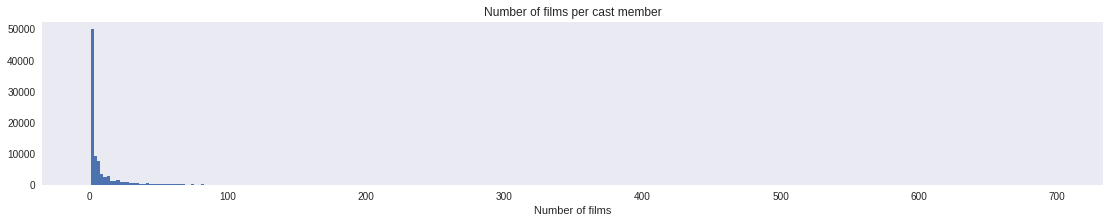

In [214]:
figure, axes = plt.subplots(1,1)

num_bins = int(np.sqrt(len(dfPeopleMoviesCast.merge(dfCastIds, how='inner')['people_id'].unique())))
plt.hist(dfPeopleMoviesCast.merge(dfCastIds, how='inner')['people_id'].value_counts(), bins=num_bins);

plt.grid(False);
plt.xlabel('Number of films');
plt.title('Number of films per cast member');
#plt.xlim(,);
#plt.ylim(,);
figure.set_size_inches([19,3])

plt.show()

In [215]:
#Hay muchísimos actores que sólo han hecho un peli en toda su vida.
dfPeopleMoviesCast.merge(dfCastIds, how='inner')['people_id'].value_counts().describe()

count    88541.000000
mean         8.825245
std         17.036559
min          1.000000
25%          1.000000
50%          3.000000
75%          8.000000
max        698.000000
Name: people_id, dtype: float64

In [216]:
#30568 actores sólo hicieron una peli
pd.Series(dfPeopleMoviesCast.merge(dfCastIds, how='inner')['people_id'].value_counts()).value_counts().head(20)

1     30568
2     11878
3      7364
4      5290
5      3869
6      3055
7      2540
8      2110
9      1724
10     1605
11     1318
12     1128
13     1064
14      927
15      869
16      708
18      671
17      654
19      611
20      534
Name: people_id, dtype: int64

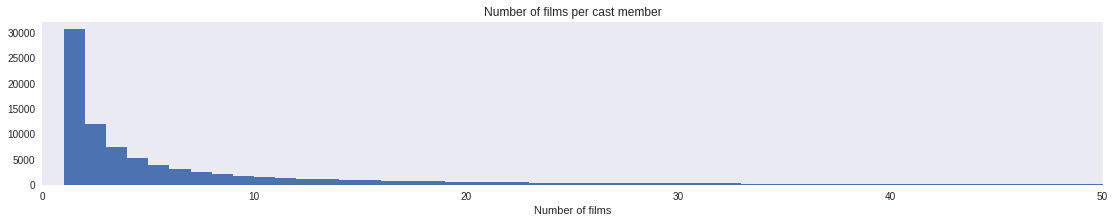

In [217]:
#Recordar: tengo 88541 actores
figure, axes = plt.subplots(1,1)

num_bins = 698
plt.hist(dfPeopleMoviesCast.merge(dfCastIds, how='inner')['people_id'].value_counts(), bins=num_bins);

plt.grid(False);
plt.xlabel('Number of films');
plt.title('Number of films per cast member');
plt.xlim(0,50);
#plt.ylim(,);
figure.set_size_inches([19,3])

plt.show()

In [218]:
#¿Cuántos, de mis 88541, han hecho 1 o 2 pelis?
sum(dfPeopleMoviesCast.merge(dfCastIds, how='inner')['people_id'].value_counts()<3)

42446

In [219]:
#¿Cuántos, de mis 88541, han hecho más de 10 pelis?
sum(dfPeopleMoviesCast.merge(dfCastIds, how='inner')['people_id'].value_counts()>10)

18538

In [220]:
#¿Cuánto sobre mis 88541 representan los que han hecho más de 20 pelis?
sum(dfPeopleMoviesCast.merge(dfCastIds, how='inner')['people_id'].value_counts()>38)/88541

0.05049638020803921

In [0]:
dfPeople_NumMovies =  pd.DataFrame(dfPeopleMoviesCast.merge(dfCastIds, how='inner')['people_id'].value_counts())
dfPeople_NumMovies.columns = ['numMovies']

In [0]:
dfPeople_NumMovies['people_id'] = dfPeople_NumMovies.index

In [0]:
dfPeople_NumMovies['aux'] = 0

In [224]:
dfPeople_NumMovies.head(5)

,numMovies,people_id,aux
33923,698,33923,0
124097,540,124097,0
121323,528,121323,0
55680,482,55680,0
130111,353,130111,0


In [225]:
from sklearn.cluster import KMeans
#kmeans = KMeans(n_clusters=3, random_state=0)
kmeans = KMeans(n_clusters=3)
kmeans.fit(dfPeople_NumMovies[['numMovies', 'aux']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [0]:
#KMeans?

In [0]:
dfPeople_NumMovies['cluster'] = kmeans.predict(dfPeople_NumMovies[['numMovies', 'aux']])

In [228]:
dfPeople_NumMovies.groupby('cluster')['numMovies'].agg(['min','max','count'])

,min,max,count
cluster,,,
0,1,17,76671
1,63,698,1838
2,18,62,10032


In [229]:
dfPeople.merge(dfPeople_NumMovies, how='inner', on='people_id')[dfPeople.merge(dfPeople_NumMovies, how='inner', on='people_id')['cluster']==1][['cluster', 'people_id', 'name', 'numMovies']].head(5)

,cluster,people_id,name,numMovies
14,1,6264,Udo Samel,67
15,1,7166,Kevin Pollak,89
134,1,102306,Armando Silvestre,93
256,1,4961,Gabriele Ferzetti,97
263,1,7664,Joseph Cotten,85


In [230]:
dfPeople.merge(dfPeople_NumMovies, how='inner', on='people_id')[dfPeople.merge(dfPeople_NumMovies, how='inner', on='people_id')['people_id']==6885][['cluster', 'people_id', 'name', 'numMovies']]

,cluster,people_id,name,numMovies
49532,2,6885,Charlize Theron,55


#####En el bloque siguiente, importo todas las pelis y les repito las operaciones pasadas. Necesito, para todas las pelis, budget y order en el cast.

In [231]:
path = "./themoviedb_data/movies"
dfMoviesAll = pd.DataFrame()

def moviesIterator(path):
    intI = 0
    for root, dirs, files in os.walk(path):
        for f in files:
            intI += 1
            if f.endswith('.json'):
                fp = os.path.join(root,f)
                with open(fp) as o:
                    data = ujson.load(o)
                
                if intI % 25000 == 0:
                    print(intI)
                    
                result = {"budget": data["budget"], "credits_cast": data["credits"]["cast"], 
                          "credits_crew": data["credits"]["crew"], "movie_id": data["id"], "imdb_id": data["imdb_id"]}                
                 
                if data["adult"] == False:
                    yield result
                      
tic=timeit.default_timer()
dfMoviesAll = pd.DataFrame(moviesIterator(path))
#dfMovies.set_index('id', inplace=True)
toc=timeit.default_timer()
toc - tic #elapsed time in seconds

25000
50000
75000
100000
125000
150000
175000
200000
225000
250000
275000
300000
325000
350000
375000
400000


384.10967560100016

In [232]:
dfMoviesAll.shape

(393239, 5)

In [233]:
dfMoviesAll.head(5)

,budget,credits_cast,credits_crew,imdb_id,movie_id
0,0,"[{'cast_id': 12, 'character': 'Pavol Barabáš',...","[{'credit_id': '59c178fac3a3684cec000e5f', 'de...",tt1675148,169804
1,0,"[{'cast_id': 0, 'character': 'Director', 'cred...","[{'credit_id': '59f3caecc3a36820010020ca', 'de...",tt7434894,483806
2,0,"[{'cast_id': 1, 'character': 'Bébé mother', 'c...","[{'credit_id': '57e414bd9251411d7d003fa7', 'de...",tt0208831,417405
3,0,"[{'cast_id': 0, 'character': 'Étienne', 'credi...","[{'credit_id': '5a25dd2e92514103300dd7d5', 'de...",tt6593240,490862
4,0,"[{'cast_id': 11, 'character': 'John Thomas', '...","[{'credit_id': '52fe4c00c3a36847f821cda7', 'de...",tt2207006,119446


In [234]:
dfMoviesAll.isnull().sum()

budget              0
credits_cast        0
credits_crew        0
imdb_id         55859
movie_id            0
dtype: int64

In [235]:
#Controlo 0's en los numéricos:
dfMoviesAll[dfMoviesAll.columns[(dfMoviesAll.dtypes == 'float64') | (dfMoviesAll.dtypes == 'int64')]].applymap(lambda num: num==0).sum()

budget      374718
movie_id         0
dtype: int64

In [0]:
#Esta función requiere que el index sea el id de la película. Podría cambiarse para que no fuese así, pero sería mucho más lenta.
dfMoviesAll.index = dfMoviesAll['movie_id']

In [0]:
def columnIteratorMoviesAll(columnName, *args):
    for id in dfMoviesAll.index:
        for dict in dfMoviesAll[dfMoviesAll.index == id][columnName].iloc[0]:
            outputDict = {'movie_id': id}
            for key in args:
                outputDict[key] = dict.get(key,None)
            yield outputDict

#Creo mi dataframe con la info de la columna correspondiente, compruebo que tiene el nº filas que ha de tener y, si es así, elimino la columna
#correspondiente en dfMovies. Haré todo esto con la siguiente función:
def columnProcessesMoviesAll (columnName, *args):
    #I need to declare dfMovies as global as I will change it inside this function.
    global dfMoviesAll
    
    dfOutput = pd.DataFrame()
    dfOutput = pd.DataFrame(columnIteratorMoviesAll(columnName, *args))
    
    #Compruebo que tiene el nº de registros que ha de tener.
    dfCheck = pd.DataFrame(dfMoviesAll[columnName].map(len).value_counts())
    dfCheck['calculation']=dfCheck[columnName]*dfCheck.index
    
    if dfOutput.shape[0] == dfCheck['calculation'].sum():
        dfMoviesAll = dfMoviesAll.drop(columnName, axis=1)
        return dfOutput
    else:
        return "Error in process"                  

In [238]:
dfMoviesAllCast = columnProcessesMoviesAll ('credits_cast', 'cast_id', 'character', 'gender', 'id', 'name', 'order')
print("dfMoviesAllCast generated")

dfMoviesAllCrew = columnProcessesMoviesAll ('credits_crew', 'department', 'gender', 'id', 'job', 'name')
print("dfMoviesAllCrew generated")

dfMoviesAllCast generated
dfMoviesAllCrew generated


In [0]:
my_file_path='./IMDB_5000_movie.csv'
dfMovies5000 = pd.read_csv(my_file_path)

#Construyo una nueva columna con el identificador de imdb: id_imdb
dfMovies5000['imdb_id'] = dfMovies5000['movie_imdb_link'].str.split("/").map(lambda list: list[4])

#O sea: los duplicados a nivel de clave lo son también a nivel de gross y budget salvo por un registro. Voy a eliminar los
#duplicados a nivel de clave quedándome con el primero de los registros que me encuentre (SIMPLIFICACIÓN).
dfMovies5000 = dfMovies5000.drop_duplicates(subset='imdb_id', keep='first')

#Debería sustituir las cadenas de longitud vacía por nulos, para tener un criterio homogéneo. Lo hago:
#Podría mejorarlo (si necesito aplicarlo a otros) y convertir cualquier cadena de longitud vacía en nulos.
#Esta función se aplica a cualquier tipo de dato y devuelvo un None si la entrada es ''
def fill_blank_with_nones(value):
    if value=='':
        return None
    else:
        return value
      
dfMoviesAll['imdb_id']=dfMoviesAll['imdb_id'].map(fill_blank_with_nones)  

#Quiero cambiar el nombre de algunas columnas antes de cruzar, para que sean más fácilmente identificables:
def change_column_names(str):
    if str == 'budget':
        return 'imdb_budget'
    elif str == 'gross':
        return 'imdb_revenue'
    else:
        return str

dfMovies5000.columns = list(map(change_column_names, dfMovies5000.columns.tolist()))

#Hago el cruce:
dfMoviesAll = dfMoviesAll.merge(dfMovies5000[['imdb_id', 'imdb_budget']], how='left', left_on='imdb_id', right_on='imdb_id')

#Pero ahora tengo distinto criterio en budget y revenue para tmdb e imdb:
#Igualo criterios:
def change_none_to_zero(num):
    if num != num or num is None:
        return 0
    else:
        return num
      
dfMoviesAll['imdb_budget'] = dfMoviesAll['imdb_budget'].map(change_none_to_zero)

In [0]:
#No me va a importar mucho si un actor hace dos personajes en una peli, que es la única cosa en la que podría tener duplicidad.
#Prefiero saber que el actor participó en esa peli. Así que me voy a quedar con uno de los registros:
dfMoviesAllCast = dfMoviesAllCast.drop_duplicates(subset=['movie_id', 'id'], keep='first')

#Como medida de seguridad, elimino los blancos que pudiese haber en "job":
dfMoviesAllCrew['job'] = dfMoviesAllCrew['job'].str.strip()
dfMoviesAllCrew = dfMoviesAllCrew.drop_duplicates(subset=['movie_id', 'id', 'job'], keep='first')

In [0]:
#Deshago un cambio que hice más atrás: tener 0's en revenue y budget me estropean el análisis. Los cambios por NaN
def change_zero_to_none(num):
    if num != num or num is None:
        return None
    elif num == 0:
        return None
    else:
        return num

dfMoviesAll['imdb_budget'] = dfMoviesAll['imdb_budget'].map(change_zero_to_none)
dfMoviesAll['budget'] = dfMoviesAll['budget'].map(change_zero_to_none)

In [0]:
#1: Anulo el budget cuando el dato es menor que 100$:   QUIZÁ ES UNA MALA PRÁCTICA, PORQUE PIERDO LA VISIBILIDAD DEL DATO INICIAL.
#Aunque siempre tengo dfMovies.
dfMoviesAll.loc[dfMoviesAll['budget']<100, 'budget'] = None
dfMoviesAll.loc[dfMoviesAll['imdb_budget']<100, 'imdb_budget'] = None  #Aunque no tiene efectos (porque no hay ninguno), lo hago, por si cambio la base.

#2: Tomo el dato de TMDB, a no ser que sea nulo, en cuyo caso tomo el de IMDB.
#Y no aplico ninguna restricción al año 2016 (entiendo que el budget, a diferencia del revenue, está bien recogido para IMDB.)
dfMoviesAll['budget_final'] = dfMoviesAll['budget'].combine_first(dfMoviesAll['imdb_budget'])

In [243]:
for column in dfMoviesAllCast.columns[dfMoviesAllCast.dtypes == 'object']:
    dfMoviesAllCast[column] = dfMoviesAllCast[column].str.strip()
print('dfMoviesAllCast done')    

for column in dfMoviesAllCrew.columns[dfMoviesAllCrew.dtypes == 'object']:
    dfMoviesAllCrew[column] = dfMoviesAllCrew[column].str.strip()
print('dfMoviesAllCrew done')    

dfMoviesAllCast done
dfMoviesAllCrew done


#####Sigo ahora con mi procedimiento para clusterizar los actores:

In [244]:
#Controlo 0's en los numéricos:
dfMoviesAll[dfMoviesAll.columns[(dfMoviesAll.dtypes == 'float64') | (dfMoviesAll.dtypes == 'int64')]].applymap(lambda num: num==0).sum()

budget          0
movie_id        0
imdb_budget     0
budget_final    0
dtype: int64

In [245]:
dfMoviesAll.isnull().sum()

budget          376104
imdb_id         101697
movie_id             0
imdb_budget     388825
budget_final    375399
dtype: int64

In [246]:
dfPeopleMoviesCast.merge(dfCastIds, how='inner')['release_date'].sort_values().head(5)

119129   1897-09-22
478851   1899-01-01
290338   1900-01-01
104863   1900-01-01
497209   1900-11-21
Name: release_date, dtype: datetime64[ns]

In [247]:
dfPeopleMoviesCast.merge(dfCastIds, how='inner')[dfPeopleMoviesCast.merge(dfCastIds, how='inner')['release_date']<'1900-01-01']

,adult,character,genre_ids,id,original_language,original_title,people_id,popularity,release_date,title,vote_average,vote_count
119129,False,,[],453763,en,Ambulance at the Accident,1234935,0.060,1897-09-22,Ambulance at the Accident,6.0,1
478851,False,Comandante Aguirre,"[28, 80, 18]",542463,es,Marcado por el Odio,1634678,0.001,1899-01-01,Marcado por el Odio,0.0,0


In [248]:
my_file_path='./InflationConverter.xlsx'
dfInflationConverter = pd.read_excel(my_file_path)
dfInflationConverter.shape

(106, 2)

In [249]:
dfInflationConverter.head(5)

,Year,InflationConverter
0,2018,100.00
1,2017,102.99
2,2016,105.18
3,2015,106.51
4,2014,106.63


In [250]:
dfInflationConverter.tail(5)

,Year,InflationConverter
101,1917,1972.18
102,1916,2315.95
103,1915,2499.40
104,1914,2524.39
105,1913,2549.89


In [0]:
#En dfPeopleMoviesCast tengo todas las pelis que han hecho los actores. 
#Cruzando con dfCastIds tengo todas las pelis que han hecho mis actores (es decir, los actores de las pelis que quiero analizar.)
#En esta tabla, dfPeopleMoviesCast, es donde quiero incorporar la info que necesito para clusterizar los actores:
#    1. Presupuesto de la peli limpio de inflación
#    2. Orden en el cast
#Después, a partir de dfPeopleMoviesCast así actualizada, podré agrupar por people_id y tendré la tabla base para mi clustering.

In [252]:
dfPeopleMoviesCast.shape

(994117, 12)

In [253]:
#Para facilitar la escritura en adelante, me quedo en dfPeopleMoviesCast con mis actores y sus pelis:
dfPeopleMoviesCast = dfPeopleMoviesCast.merge(dfCastIds, how='inner')
dfPeopleMoviesCast.shape

(781396, 12)

In [254]:
#Cruzo con dfMoviesAll para incorporar la información del presupuesto:
dfPeopleMoviesCast = dfPeopleMoviesCast.merge(dfMoviesAll[['movie_id','budget_final']], how='left', left_on='id', right_on='movie_id')
dfPeopleMoviesCast.shape

(781396, 14)

In [255]:
dfPeopleMoviesCast.columns

Index(['adult', 'character', 'genre_ids', 'id', 'original_language',
       'original_title', 'people_id', 'popularity', 'release_date', 'title',
       'vote_average', 'vote_count', 'movie_id', 'budget_final'],
      dtype='object')

In [256]:
#Para algunos actores, algunas de sus pelis no han encontrado valor en dfMoviesAll
dfPeopleMoviesCast['movie_id'].isnull().sum()

7310

In [257]:
#No voy a usar esta información. Y como no quiero confundirme con dos id's de película, me cargo el último menos informado:
dfPeopleMoviesCast = dfPeopleMoviesCast.drop('movie_id', axis=1)
dfPeopleMoviesCast.columns

Index(['adult', 'character', 'genre_ids', 'id', 'original_language',
       'original_title', 'people_id', 'popularity', 'release_date', 'title',
       'vote_average', 'vote_count', 'budget_final'],
      dtype='object')

In [258]:
#Voy a incorporar la info del presupuesto limpio de inflación. Esta info la tengo desde 1913. Voy a aprovechar y cargarme la info de pelis
#anteriores a 1913 o posteriores a 2018 (programadas??), que o no voy a usar, o en su mayoría, corresponden a errores. 
#Y me cargo también la info de pelis que no tienen release_date:
dfPeopleMoviesCast[(dfPeopleMoviesCast['release_date'].isnull()) | (dfPeopleMoviesCast['release_date']<'1913-01-01') | (dfPeopleMoviesCast['release_date']>'2018-12-31')].shape[0]

10329

In [259]:
dfPeopleMoviesCast['release_year'] = dfPeopleMoviesCast['release_date'].map(lambda datetime: datetime.year)
dfPeopleMoviesCast.columns

Index(['adult', 'character', 'genre_ids', 'id', 'original_language',
       'original_title', 'people_id', 'popularity', 'release_date', 'title',
       'vote_average', 'vote_count', 'budget_final', 'release_year'],
      dtype='object')

In [260]:
dfPeopleMoviesCast[['release_year', 'release_date']].isnull().sum()

release_year    8563
release_date    8563
dtype: int64

In [261]:
dfPeopleMoviesCast['release_year'].dtypes

dtype('float64')

In [262]:
#¿Me dará problema el que Year tenga distinto tipo que release_year?
dfInflationConverter.dtypes

Year                    int64
InflationConverter    float64
dtype: object

In [263]:
#No me da problema:
dfPeopleMoviesCast.merge(dfInflationConverter, how='inner', left_on='release_year', right_on='Year').shape

(771067, 16)

In [264]:
#Porque yo esperaba este número de filas:
781396-10329

771067

In [265]:
dfPeopleMoviesCast = dfPeopleMoviesCast.merge(dfInflationConverter, how='inner', left_on='release_year', right_on='Year')
dfPeopleMoviesCast.shape

(771067, 16)

In [266]:
dfPeopleMoviesCast.columns

Index(['adult', 'character', 'genre_ids', 'id', 'original_language',
       'original_title', 'people_id', 'popularity', 'release_date', 'title',
       'vote_average', 'vote_count', 'budget_final', 'release_year', 'Year',
       'InflationConverter'],
      dtype='object')

In [267]:
dfPeopleMoviesCast = dfPeopleMoviesCast.drop('Year', axis=1)
dfPeopleMoviesCast.columns

Index(['adult', 'character', 'genre_ids', 'id', 'original_language',
       'original_title', 'people_id', 'popularity', 'release_date', 'title',
       'vote_average', 'vote_count', 'budget_final', 'release_year',
       'InflationConverter'],
      dtype='object')

In [0]:
dfPeopleMoviesCast['budget_converted'] = dfPeopleMoviesCast['budget_final'] * dfPeopleMoviesCast['InflationConverter']/100

In [269]:
dfPeopleMoviesCast[['budget_final', 'InflationConverter', 'budget_converted']].head()

,budget_final,InflationConverter,budget_converted
0,8000000.0,185.34,14827200.0
1,NaN,185.34,NaN
2,25000000.0,185.34,46335000.0
3,NaN,185.34,NaN
4,6000000.0,185.34,11120400.0


In [270]:
dfPeopleMoviesCast[['budget_final', 'InflationConverter', 'budget_converted']].isnull().sum()

budget_final          577126
InflationConverter         0
budget_converted      577126
dtype: int64

In [271]:
#0's no tengo porque los eliminé.
dfPeopleMoviesCast[['budget_final', 'budget_converted']].describe()

,budget_final,budget_converted
count,1.939410e+05,1.939410e+05
mean,3.451764e+07,4.605661e+07
std,6.223010e+07,7.664730e+07
min,1.000000e+02,1.029900e+02
25%,5.000000e+06,8.236900e+06
50%,1.600000e+07,2.555100e+07
75%,4.000000e+07,6.060800e+07
max,4.200000e+09,5.428920e+09


In [272]:
#Voy a actualizar los blancos de budget_converted con la mediana. Pero calculada al nivel película, no actor-película:
dfPeopleMoviesCast['budget_converted'].median()

25551000.0

In [273]:
#Observar que el dato es mucho menor!!!! ¿Qué sesgo estoy cometiendo al hacer esto?!!!!!!!!!!!!! (completar tantos 0's con la mediana)
auxBudgetMedian = dfPeopleMoviesCast.drop_duplicates(subset='id', keep='first')['budget_converted'].median()
auxBudgetMedian

6707190.0

In [274]:
dfPeopleMoviesCast.drop_duplicates(subset='id', keep='first')['budget_converted'].describe()

count    1.351500e+04
mean     2.356246e+07
std      6.784936e+07
min      1.029900e+02
25%      1.099500e+06
50%      6.707190e+06
75%      2.707705e+07
max      5.428920e+09
Name: budget_converted, dtype: float64

In [275]:
#Como es de esperar, la mediana de budget_converted no varía con el cambio.
dfPeopleMoviesCast.fillna({'budget_converted': auxBudgetMedian}).describe()

,id,people_id,popularity,vote_average,vote_count,budget_final,InflationConverter,budget_converted
count,771067.000000,7.710670e+05,771067.000000,771067.000000,771067.000000,1.939410e+05,771067.000000,7.710670e+05
mean,172664.573865,2.903309e+05,2.869695,4.747117,334.257810,3.451764e+07,314.387772,1.660447e+07
std,158208.611502,5.036102e+05,5.530897,2.748452,1239.404726,6.223010e+07,388.292640,4.206114e+07
min,2.000000,1.000000e+00,0.000000,0.000000,0.000000,1.000000e+02,100.000000,1.029900e+02
25%,32241.000000,1.700500e+04,0.148000,3.600000,1.000000,5.000000e+06,112.230000,6.707190e+06
50%,113225.000000,6.207000e+04,0.750000,5.800000,5.000000,1.600000e+07,142.620000,6.707190e+06
75%,297596.000000,1.544950e+05,4.050000,6.700000,63.000000,4.000000e+07,253.450000,6.707190e+06
max,546336.000000,2.115927e+06,253.501000,10.000000,18623.000000,4.200000e+09,2549.890000,5.428920e+09


In [0]:
#Hago el cambio:     ¿DEBERÍA HABER CREADO UN CAMPO MARCANDO QUÉ VALORES ERAN NULOS?!!!!!
#Antes de hacerlo, estaría bien ver los cuartiles de esta variable, para ver si el criterio que tomaré después de "gran producción" es razonable.
dfPeopleMoviesCast = dfPeopleMoviesCast.fillna({'budget_converted': auxBudgetMedian})

In [277]:
#Voy a hacer un cluster de los presupuestos de las pelis:
dfAuxMoviesBudget = dfPeopleMoviesCast.drop_duplicates(subset='id', keep='first')[['id', 'budget_converted']]
dfAuxMoviesBudget.shape

(166392, 2)

In [278]:
dfAuxMoviesBudget.head()

,id,budget_converted
0,30815,14827200.0
1,455569,6707190.0
2,1497,46335000.0
3,123598,6707190.0
4,27549,11120400.0


In [279]:
from sklearn.cluster import KMeans
#kmeans = KMeans(n_clusters=3, random_state=0)
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(dfAuxMoviesBudget[['budget_converted']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [0]:
dfAuxMoviesBudget['cluster'] = kmeans.predict(dfAuxMoviesBudget[['budget_converted']])

In [281]:
dfAuxMoviesBudget.groupby('cluster')['budget_converted'].agg(['min','max','count'])

,min,max,count
cluster,,,
0,1.029900e+02,6.157200e+07,164933
1,3.231500e+09,5.428920e+09,2
2,6.172650e+07,1.084090e+09,1457


In [282]:
#Qué pelis son esas dos?
dfAuxMoviesBudget[dfAuxMoviesBudget['budget_converted']>2e9]['id']

562361     4550
578539    41508
Name: id, dtype: int64

In [283]:
#Avatar fue la película más cara de la historia, con 425 mill $ de presupuesto. ¿Cuántas pelis tengo con presupuesto mayor?
dfAuxMoviesBudget[dfAuxMoviesBudget['budget_converted']>425e6]['id'].shape[0]

9

In [284]:
dfAuxMoviesBudget['budget_converted'].sort_values(ascending=False).head(9)

562361    5.428920e+09
578539    3.231500e+09
217830    1.084090e+09
658351    7.254000e+08
288564    6.946200e+08
678518    6.687120e+08
476350    5.704800e+08
228298    5.149500e+08
83270     4.264740e+08
Name: budget_converted, dtype: float64

In [285]:
#Creo que son errores.
dfPeopleMoviesCast.drop_duplicates(subset='id', keep='first')[(dfPeopleMoviesCast['id']==41508) | (dfPeopleMoviesCast['id']==4550)][['title', 'release_date', 'original_title', 'popularity']]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,title,release_date,original_title,popularity
562361,Sympathy for Lady Vengeance,2005-09-30,친절한 금자씨,8.164
578539,Fateless,2005-02-10,Sorstalanság,2.335


In [0]:
#Me los cargo y repito el clustering:
dfAuxMoviesBudget = dfAuxMoviesBudget.drop(dfAuxMoviesBudget[dfAuxMoviesBudget['budget_converted']>2e9].index)

In [287]:
from sklearn.cluster import KMeans
#kmeans = KMeans(n_clusters=3, random_state=0)
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(dfAuxMoviesBudget[['budget_converted']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [288]:
dfAuxMoviesBudget['cluster'] = kmeans.predict(dfAuxMoviesBudget[['budget_converted']])
dfAuxMoviesBudget.groupby('cluster')['budget_converted'].agg(['min','max','count'])

,min,max,count
cluster,,,
0,1.029900e+02,3.555520e+07,163733
1,3.562010e+07,1.222900e+08,2193
2,1.229488e+08,1.084090e+09,464


In [0]:
#Podría decir que el grupo 1 son películas de elevado presupuesto, y las del grupo 2 son grandes superproducciones.
#Voy a analizar qué actores han trabajado en pelis del grupo 1 o 2.

In [0]:
#Incorporo ahora esta información en mi tabla de people-movies:
dfPeopleMoviesCast['budget_cluster'] = kmeans.predict(dfPeopleMoviesCast[['budget_converted']])

In [291]:
dfPeopleMoviesCast.describe()

,id,people_id,popularity,vote_average,vote_count,budget_final,InflationConverter,budget_converted,budget_cluster
count,771067.000000,7.710670e+05,771067.000000,771067.000000,771067.000000,1.939410e+05,771067.000000,7.710670e+05,771067.000000
mean,172664.573865,2.903309e+05,2.869695,4.747117,334.257810,3.451764e+07,314.387772,1.660447e+07,0.124302
std,158208.611502,5.036102e+05,5.530897,2.748452,1239.404726,6.223010e+07,388.292640,4.206114e+07,0.395055
min,2.000000,1.000000e+00,0.000000,0.000000,0.000000,1.000000e+02,100.000000,1.029900e+02,0.000000
25%,32241.000000,1.700500e+04,0.148000,3.600000,1.000000,5.000000e+06,112.230000,6.707190e+06,0.000000
50%,113225.000000,6.207000e+04,0.750000,5.800000,5.000000,1.600000e+07,142.620000,6.707190e+06,0.000000
75%,297596.000000,1.544950e+05,4.050000,6.700000,63.000000,4.000000e+07,253.450000,6.707190e+06,0.000000
max,546336.000000,2.115927e+06,253.501000,10.000000,18623.000000,4.200000e+09,2549.890000,5.428920e+09,2.000000


In [292]:
#Voy a incorporar ahora la información del nº de orden en el cast. La tomo de la siguiente tabla:
dfMoviesAllCast.columns
#Aquí los primary keys son id y movie_id (mejorable: eliminé duplicados tomando uno cualquiera de los registros.)

Index(['cast_id', 'character', 'gender', 'id', 'movie_id', 'name', 'order'], dtype='object')

In [293]:
dfPeopleMoviesCast.columns

Index(['adult', 'character', 'genre_ids', 'id', 'original_language',
       'original_title', 'people_id', 'popularity', 'release_date', 'title',
       'vote_average', 'vote_count', 'budget_final', 'release_year',
       'InflationConverter', 'budget_converted', 'budget_cluster'],
      dtype='object')

In [294]:
dfPeopleMoviesCast.shape

(771067, 17)

In [295]:
#Compruebo antes cuántos cruzan:
dfPeopleMoviesCast.merge(dfMoviesAllCast, how='inner', left_on=['id','people_id'], right_on=['movie_id', 'id']).shape

(763535, 24)

In [296]:
dfPeopleMoviesCast = dfPeopleMoviesCast.merge(dfMoviesAllCast[['movie_id', 'id', 'order']], how='left', left_on=['id','people_id'], right_on=['movie_id', 'id'])
dfPeopleMoviesCast.shape

(771067, 20)

In [297]:
dfPeopleMoviesCast.columns

Index(['adult', 'character', 'genre_ids', 'id_x', 'original_language',
       'original_title', 'people_id', 'popularity', 'release_date', 'title',
       'vote_average', 'vote_count', 'budget_final', 'release_year',
       'InflationConverter', 'budget_converted', 'budget_cluster', 'movie_id',
       'id_y', 'order'],
      dtype='object')

In [298]:
dfPeopleMoviesCast = dfPeopleMoviesCast.drop(['movie_id', 'id_y'], axis=1)
dfPeopleMoviesCast.columns

Index(['adult', 'character', 'genre_ids', 'id_x', 'original_language',
       'original_title', 'people_id', 'popularity', 'release_date', 'title',
       'vote_average', 'vote_count', 'budget_final', 'release_year',
       'InflationConverter', 'budget_converted', 'budget_cluster', 'order'],
      dtype='object')

In [299]:
#Vuelvo a cambiar el nombre de la columna:
dfPeopleMoviesCast = dfPeopleMoviesCast.rename(columns={'id_x': 'id'})
dfPeopleMoviesCast.columns

Index(['adult', 'character', 'genre_ids', 'id', 'original_language',
       'original_title', 'people_id', 'popularity', 'release_date', 'title',
       'vote_average', 'vote_count', 'budget_final', 'release_year',
       'InflationConverter', 'budget_converted', 'budget_cluster', 'order'],
      dtype='object')

In [300]:
dfPeopleMoviesCast.describe()

,id,people_id,popularity,vote_average,vote_count,budget_final,InflationConverter,budget_converted,budget_cluster,order
count,771067.000000,7.710670e+05,771067.000000,771067.000000,771067.000000,1.939410e+05,771067.000000,7.710670e+05,771067.000000,763535.000000
mean,172664.573865,2.903309e+05,2.869695,4.747117,334.257810,3.451764e+07,314.387772,1.660447e+07,0.124302,9.488302
std,158208.611502,5.036102e+05,5.530897,2.748452,1239.404726,6.223010e+07,388.292640,4.206114e+07,0.395055,14.191721
min,2.000000,1.000000e+00,0.000000,0.000000,0.000000,1.000000e+02,100.000000,1.029900e+02,0.000000,0.000000
25%,32241.000000,1.700500e+04,0.148000,3.600000,1.000000,5.000000e+06,112.230000,6.707190e+06,0.000000,2.000000
50%,113225.000000,6.207000e+04,0.750000,5.800000,5.000000,1.600000e+07,142.620000,6.707190e+06,0.000000,5.000000
75%,297596.000000,1.544950e+05,4.050000,6.700000,63.000000,4.000000e+07,253.450000,6.707190e+06,0.000000,11.000000
max,546336.000000,2.115927e+06,253.501000,10.000000,18623.000000,4.200000e+09,2549.890000,5.428920e+09,2.000000,313.000000


In [301]:
dfPeopleMoviesCast.columns

Index(['adult', 'character', 'genre_ids', 'id', 'original_language',
       'original_title', 'people_id', 'popularity', 'release_date', 'title',
       'vote_average', 'vote_count', 'budget_final', 'release_year',
       'InflationConverter', 'budget_converted', 'budget_cluster', 'order'],
      dtype='object')

In [0]:
#Errores asumidos: no siempre el order empieza por 0 / no siempre el order está completo (me devolverá False en los nuevos campos)
dfPeopleMoviesCast['leadingRole_BigProduc'] = (dfPeopleMoviesCast['order']<5) & (dfPeopleMoviesCast['budget_converted']>35e6)
dfPeopleMoviesCast['leadingRole_SmallProduc'] = (dfPeopleMoviesCast['order']<5) & (dfPeopleMoviesCast['budget_converted']<=35e6)
dfPeopleMoviesCast['minorRole_BigProduc'] = (dfPeopleMoviesCast['order']>=5) & (dfPeopleMoviesCast['budget_converted']>35e6)
dfPeopleMoviesCast['minorRole_SmallProduc'] = (dfPeopleMoviesCast['order']>=5) & (dfPeopleMoviesCast['budget_converted']<=35e6)

In [303]:
#Errores asumidos: no siempre el order está completo (me devolverá False en los nuevos campos)
dfPeopleMoviesCast[dfPeopleMoviesCast['order'].isnull()].head(5)

,adult,character,genre_ids,id,original_language,original_title,people_id,popularity,release_date,title,...,budget_final,release_year,InflationConverter,budget_converted,budget_cluster,order,leadingRole_BigProduc,leadingRole_SmallProduc,minorRole_BigProduc,minorRole_SmallProduc
414,True,,[],247197,it,Cronaca nera 2: Diritto d'autore,1282595,0.465,1991-11-01,Cronaca nera 2: Diritto d'autore,...,NaN,1991,185.34,6707190.0,0,NaN,False,False,False,False
1359,True,Franklin,[],93033,en,Curse of the Catwoman,93735,0.389,1991-12-06,Curse of the Catwoman,...,NaN,1991,185.34,6707190.0,0,NaN,False,False,False,False
1360,True,Dr. Jeremy Lodge,[18],543194,en,Taboo IX,93735,0.000,1991-01-01,Taboo IX,...,NaN,1991,185.34,6707190.0,0,NaN,False,False,False,False
1722,False,,[],545684,zh,娃娃,1174366,0.150,1991-01-01,A Piggy Tale,...,NaN,1991,185.34,6707190.0,0,NaN,False,False,False,False
3279,False,Kurti,[35],267823,de,Ilona & Kurti,572,0.014,1991-01-02,Ilona & Kurti,...,NaN,1991,185.34,6707190.0,0,NaN,False,False,False,False


In [304]:
dfPeopleMoviesCast.columns

Index(['adult', 'character', 'genre_ids', 'id', 'original_language',
       'original_title', 'people_id', 'popularity', 'release_date', 'title',
       'vote_average', 'vote_count', 'budget_final', 'release_year',
       'InflationConverter', 'budget_converted', 'budget_cluster', 'order',
       'leadingRole_BigProduc', 'leadingRole_SmallProduc',
       'minorRole_BigProduc', 'minorRole_SmallProduc'],
      dtype='object')

In [305]:
#Tenía 88541 actores. Bien.
dfPeopleMoviesCast.groupby('people_id')[['leadingRole_BigProduc', 'leadingRole_SmallProduc', 'minorRole_BigProduc', 'minorRole_SmallProduc']].sum().shape

(88541, 4)

In [0]:
dfAuxPeopleCluster = dfPeopleMoviesCast.groupby('people_id')[['leadingRole_BigProduc', 'leadingRole_SmallProduc', 'minorRole_BigProduc', 'minorRole_SmallProduc']].sum().reset_index()

In [314]:
dfAuxPeopleCluster.head()

,people_id,leadingRole_BigProduc,leadingRole_SmallProduc,minorRole_BigProduc,minorRole_SmallProduc
0,1,0.0,35.0,4.0,22.0
1,2,4.0,71.0,2.0,33.0
2,3,33.0,27.0,4.0,34.0
3,4,7.0,40.0,4.0,30.0
4,5,1.0,84.0,1.0,20.0


In [327]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline

kmeans = KMeans(n_clusters=5, random_state=0)
scaler = RobustScaler()
pipe = Pipeline(steps=[('scaler', scaler), ('kmeans', kmeans)])

pipe.fit(dfAuxPeopleCluster[['leadingRole_BigProduc', 'leadingRole_SmallProduc', 'minorRole_BigProduc', 'minorRole_SmallProduc']])

Pipeline(memory=None,
     steps=[('scaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('kmeans', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0))])

In [328]:
dfAuxPeopleCluster['cluster'] = pipe.predict(dfAuxPeopleCluster[['leadingRole_BigProduc', 'leadingRole_SmallProduc', 'minorRole_BigProduc', 'minorRole_SmallProduc']])
dfAuxPeopleCluster.groupby('cluster')[['leadingRole_BigProduc', 'leadingRole_SmallProduc', 'minorRole_BigProduc', 'minorRole_SmallProduc']].agg(['min','max','count', 'median', 'mean'])

leadingRole_BigProduc                                \
                          min   max  count median      mean   
cluster                                                       
0                         0.0   9.0  73222    0.0  0.018765   
1                         0.0  47.0    657    1.0  2.747336   
2                         0.0  23.0  11012    0.0  0.275881   
3                         0.0   5.0    516    0.0  0.120155   
4                         0.0  41.0   3134    0.0  2.194001   

        leadingRole_SmallProduc                                  \
                            min    max  count median       mean   
cluster                                                           
0                           0.0   13.0  73222    0.0   0.834490   
1                          52.0  672.0    657   72.0  79.987823   
2                           0.0   23.0  11012    9.0   9.358518   
3                           0.0   85.0    516   17.0  20.521318   
4                          13.0   60.0   3134   31.0  33.276643   

        minorRole_BigProduc                                \
                        min   max  count median      mean   
cluster                                                     
0                       0.0  11.0  73222    0.0  0.551924   
1                       0.0  19.0    657    1.0  2.299848   
2                       0.0  40.0  11012    1.0  1.502906   
3                       0.0  64.0    516    1.0  1.763566   
4                       0.0  35.0   3134    1.0  2.004148   

        minorRole_SmallProduc                                  
                          min    max  count median       mean  
cluster                                                        
0                         0.0   12.0  73222    1.0   1.801890  
1                         1.0  157.0    657   21.0  24.864536  
2                         0.0   42.0  11012   10.0  11.511987  
3                        39.0  511.0    516   57.0  66.786822  
4                         0.0   45.0   3134   12.0  13.918315

In [329]:
centers = kmeans.cluster_centers_
centers

array([[ 1.87648521e-02,  2.78163211e-01,  5.51924285e-01,
        -6.60366192e-02],
       [ 2.74733638e+00,  2.66626078e+01,  2.29984779e+00,
         7.62151192e+00],
       [ 2.75880857e-01,  3.11950599e+00,  1.50290592e+00,
         3.17066231e+00],
       [ 1.20155039e-01,  6.84043928e+00,  1.76356589e+00,
         2.15956072e+01],
       [ 2.19400128e+00,  1.10922144e+01,  2.00414805e+00,
         3.97277175e+00]])